**Определение уязвимых групп населения**

*1.Сбор и обработка информации по данным таблицам по брифу:*

In [1]:
#Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import shapiro
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import mixture
from sklearn import cluster
from sklearn import metrics
from sklearn import manifold
from sklearn import model_selection
from sklearn import ensemble
import pickle
import warnings 

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Cоздадим функцию обработки таблиц
def prepare_table(Table):
    # Переименуем первый столбец
    df = Table.rename(columns={Table.columns[0]: "Регион"})
    # Выявим строки содержащие федеральный округ, федерация и район и исключим их
    fo = df[df['Регион'].str.contains('федеральный округ|Федерация|район|числе')].index
    df.drop(fo, axis = 0, inplace=True)
    # Унифицируем названия регионов
    df['Регион'] = df['Регион'].apply(change_name)
    # Назначим название региона индексом
    df["Регион"] = df["Регион"].str.strip()
    df.set_index('Регион', inplace=True)
    return df
# Удалим дублирующиеся индексы 
def Dupl_index(df):  
    dup_idx = df.index.duplicated()
    df = df.loc[~dup_idx]
    return df

**Данные по безработным будут обработанны с сайта https://gogov.ru/articles/unemployment-rate.**

**Преобразуем эти данные в датафрейм:**

In [3]:
#Необходимы данные по безработным с сайта https://gogov.ru/articles/unemployment-rate. Обработаем данные в датафрейм.

unemployed = 'Адыгея,16.8,17.0,16.4,17.3,17.6,18.2,17.7,17.3,16.6,16.5,17.2,19.1,15.2,14.7,21.4,28.0,26.2,32.9,29.1,27,27.9,28.9,Алтай,11.6,13.8,10.5,10.8,11.8,11.9,9.7,10.2,11.5,11.5,12.8,12.3,13.7,12.3,8.8,10.9,8.9,9.3,9.3,10.4,8.8,16,Алтайский,край,60.6,65.2,66.1,70.3,78.2,99.6,94.8,83.4,95.8,74.4,103.2,110.6,152.0,105.1,81.7,114.4,112.9,117.6,155.3,106.1,123.7,149,Амурская,обл.,20.7,24.0,21.9,22.8,24.3,24.6,24.0,23.5,25.7,22.7,27.0,29.6,36.7,23.2,26.1,35.3,41.4,49.8,45.0,48.4,54.5,66.1,Архангельская,обл.,35.0,38.3,33.2,35.1,36.2,40.2,40.0,43.1,36.6,32.6,36.7,44.1,45.9,43.7,35.2,39.4,35.4,47.0,68.3,56.4,59.5,87.4,Астраханская,обл.,39.0,39.6,38.7,38.6,40.0,40.0,39.7,39.7,39.9,41.0,46.8,43.1,52.4,39.4,45.2,42.4,60.5,60.2,51.8,52.3,52.6,57.9,Башкортостан,83.2,111.7,83.8,96.0,111.5,116.0,123.3,104.9,116.0,123.8,158.7,181.9,190.3,105.1,132.0,129.5,142.6,140.2,163.8,161.1,204.5,227.9,Белгородская,обл.,34.7,40.6,31.9,32.6,32.1,32.5,32.8,32.5,32.2,29.5,33.2,40.6,37.4,29.6,31.4,42.7,42.0,45.9,59.8,58.5,48.2,44.9,Брянская,обл.,20.1,23.3,22.5,24.0,27.0,28.7,29.0,31.9,33.3,32.7,45.5,51.9,68.2,42.2,42.5,44.8,43.9,58.4,47.7,54.4,63.8,88.8,Бурятия,41.3,45.0,39.9,42.2,42.4,43.5,42.4,38.5,37.0,36.5,41.6,49.3,63.3,58.6,60.5,64.2,54.9,67.9,80.8,69.7,81.3,92.9,Владимирская,обл.,27.5,39.6,29.2,33.8,35.3,41.0,42.3,32.9,29.2,34.1,44.3,46.6,66.5,44.9,53.7,86.3,72.9,73.3,81.1,83.7,80.4,95.5,Волгоградская,обл.,61.6,94.4,66.2,71.9,76.8,88.0,94.7,86.6,89.1,80.4,91.9,105.4,137.7,107.8,86.1,116.5,88.1,125.8,144.2,114.1,125,126.5,Вологодская,обл.,25.9,35.0,25.4,29.3,30.9,40.2,41.7,34.8,38.2,37.0,47.1,51.2,52.0,36.8,26.4,35.9,34.1,40.4,31.0,39.5,58.7,55.4,Воронежская,обл.,45.3,50.4,42.0,43.3,51.2,52.3,52.0,52.7,54.1,64.6,75.6,86.8,100.8,60.8,59.4,63.7,87.6,95.7,91.5,101.3,105.7,118.6,Дагестан,206.4,201.5,179.3,160.0,163.5,146.2,140.3,135.2,152.8,155.3,172.2,188.5,171.4,174.8,252.6,270.1,264.1,299.6,213.4,260,280.7,255.1,Еврейская,АО,4.3,4.9,4.8,5.6,6.9,6.9,6.7,7.5,7.3,7.4,7.6,8.2,7.4,8.4,7.9,8.5,7.2,7.3,6.3,8.6,8.6,13.9,Забайкальский,край,48.8,51.5,48.7,54.5,57.4,57.6,55.7,53.7,56.0,56.3,56.9,58.9,65.6,81.5,46.6,33.2,48.9,65.6,72.8,62.7,81.9,76.7,Ивановская,обл.,23.7,27.9,19.5,22.1,25.4,29.9,30.9,22.9,28.7,35.0,36.7,42.2,58.8,29.5,24.1,23.5,39.5,26.9,36.5,39.1,33.9,61.4,Ингушетия,82.3,77.7,68.2,66.4,67.6,69.8,68.2,63.2,87.7,96.3,91.9,89.0,95.3,78.5,65.9,63.7,110.6,57.5,68.0,66.5,51.4,30.8,Иркутская,обл.,68.8,89.0,77.0,89.3,105.3,110.2,103.1,109.7,104.4,97.8,114.9,127.3,137.9,109.9,104.9,108.3,127.5,136.8,145.0,141.5,144.9,156.4,Кабардино-Балкария,52.8,66.9,47.7,47.0,45.3,44.5,43.2,41.2,44.2,34.1,38.8,48.2,56.4,67.7,72.5,88.8,91.1,95.1,90.7,71.7,63.1,68.1,Калининградская,обл.,27.1,31.3,23.8,24.8,26.9,31.5,30.5,28.8,29.7,38.8,47.8,52.4,55.6,45.7,17.8,22.2,33.4,33.0,37.9,35.1,39.1,77.4,Калмыкия,12.1,12.9,12.2,13.4,13.9,15.3,15.4,16.0,17.7,19.1,21.2,22.0,25.1,24.1,21.7,25.1,26.7,30.9,24.0,25,26.5,29.8,Калужская,обл.,21.6,25.4,19.8,21.4,21.6,22.7,22.9,22.4,24.8,23.6,31.2,37.6,35.0,25.9,27.4,30.5,31.1,34.7,32.7,34.6,33.1,49.3,Камчатский,край,6.3,6.9,6.8,8.8,7.7,7.6,8.4,11.5,10.8,10.9,11.7,13.3,14.4,16.8,17.9,15.9,17.3,21.3,26.2,24,31.5,34.6,Карачаево-Черкесия,26.2,30.1,23.8,25.9,28.4,30.9,32.8,29.6,22.2,21.1,22.9,23.9,28.5,34.4,41.4,40.8,29.3,32.9,34.7,23.7,35.7,40.6,Карелия,19.5,26.0,22.6,27.0,27.4,30.2,28.7,26.4,27.0,23.1,28.4,32.5,34.0,29.6,21.5,12.4,32.6,27.8,30.8,29.6,32.5,43,Кемеровская,обл.,68.5,85.4,70.8,80.9,95.1,107.7,105.5,88.0,85.3,98.9,113.9,125.9,138.6,95.2,89.6,107.2,127.0,143.9,144.4,135.2,141.7,156.7,Кировская,обл.,30.9,34.1,30.4,34.2,35.6,36.5,36.2,34.4,38.3,48.8,58.8,63.5,81.0,54.7,43.8,61.3,57.1,68.7,58.1,55.9,63.9,67.7,Коми,28.5,32.1,29.1,32.0,34.8,40.4,33.2,28.7,35.3,31.5,41.0,52.1,58.8,39.0,54.0,64.6,59.6,65.6,66.7,49.3,75.8,65.9,Костромская,обл.,13.5,17.1,12.6,14.3,17.3,18.1,17.3,14.5,17.1,16.8,18.1,21.4,29.7,18.1,12.2,18.2,18.0,21.8,22.0,18.5,22.2,33.3,Краснодарский,край,142.2,160.0,135.7,145.4,158.4,159.5,162.5,148.8,160.0,146.8,153.2,173.1,190.5,125.2,168.3,177.6,178.6,209.8,237.7,185.7,257.2,308.5,Красноярский,край,52.0,87.9,66.6,73.3,85.4,90.2,93.3,76.3,86.1,84.0,90.4,97.1,145.5,95.8,118.1,138.2,152.0,127.9,147.4,119.8,148.2,189.8,Крым,53.4,58.5,51.4,53.8,58.4,61.7,69.2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Курганская,обл.,27.9,30.4,28.4,30.6,36.7,34.5,31.8,29.9,33.2,37.7,44.4,55.3,58.1,42.4,36.9,57.3,55.2,60.6,46.3,51.2,62.4,67.3,Курская,обл.,22.7,27.1,22.5,23.0,23.5,24.4,24.0,22.5,26.6,28.9,36.1,47.6,51.0,37.3,29.1,42.5,43.7,44.4,49.5,43.8,64.1,66.5,Ленинградская,обл.,36.9,51.9,37.6,39.8,45.1,44.3,48.8,43.2,40.9,31.7,42.2,49.9,66.6,57.9,37.2,54.1,65.9,62.2,74.9,58.9,61.9,82.4,Липецкая,обл.,25.3,25.8,22.3,23.0,23.1,23.6,24.1,22.0,22.4,22.6,29.9,27.8,34.9,30.7,16.7,30.0,48.3,25.6,27.0,29.7,38.4,52.1,Магаданская,обл.,4.3,4.9,3.9,4.4,4.8,4.0,4.0,2.9,2.8,3.4,4.5,5.7,6.7,7.4,5.8,5.3,7.0,8.7,10.8,9.1,12.7,12.9,Марий,Эл,17.7,22.1,15.4,16.6,21.3,21.3,19.0,17.3,19.2,23.8,37.6,39.4,42.1,34.1,34.6,36.3,38.2,35.9,41.8,50.6,34.1,43.7,Мордовия,17.8,21.6,18.5,17.7,18.6,18.8,18.9,19.0,20.2,22.4,24.2,25.0,24.5,12.9,16.0,20.4,28.7,26.2,33.1,40.3,44,47.1,Москва,193.5,193.0,99.5,90.1,99.6,127.1,125.2,104.4,117.1,54.8,95.4,114.8,176.3,59.2,52.0,99.5,49.5,96.3,74.1,81.4,116.5,205.3,Московская,обл.,140.5,150.3,114.1,110.6,131.1,133.2,129.3,104.9,108.0,116.3,148.4,130.5,187.4,105.7,78.8,110.8,117.9,139.9,159.8,152.5,196.9,283.5,Мурманская,обл.,24.2,31.8,22.9,29.0,30.9,34.3,35.3,30.7,33.7,36.3,40.6,41.8,37.1,32.7,30.1,33.4,44.2,54.3,52.4,54.5,69.2,72.7,Ненецкий,АО,1.6,1.9,1.8,1.8,1.8,2.0,1.8,1.2,1.6,1.6,2.0,1.5,2.3,1.9,1.5,1.3,2.5,1.7,2.0,1.5,1.5,2.4,Нижегородская,обл.,73.1,80.0,71.4,73.1,75.2,76.3,75.2,75.2,75.8,98.1,128.7,137.7,135.1,101.3,82.3,96.5,107.2,133.3,112.3,141.5,149.2,144.4,Новгородская,обл.,12.2,16.7,11.0,13.0,14.9,15.6,14.8,12.0,15.6,13.8,16.5,19.2,21.0,16.7,18.1,18.7,20.3,21.2,17.6,21.5,23.1,27.5,Новосибирская,обл.,87.4,92.8,86.9,96.2,85.3,107.6,98.9,73.6,84.2,80.7,98.9,109.5,141.0,105.0,97.2,101.1,108.0,121.4,150.1,154.1,162,183.5,Омская,обл.,65.4,90.8,65.5,69.3,72.3,75.7,71.7,70.1,72.4,72.0,83.8,85.5,88.6,82.5,82.6,92.4,90.1,89.1,95.9,95.4,97.5,145.4,Оренбургская,обл.,44.4,55.4,41.2,44.7,45.7,50.0,48.9,46.4,52.6,56.0,66.0,77.0,92.6,69.5,75.4,68.5,96.4,118.1,117.4,105.1,86,127.1,Орловская,обл.,16.4,21.3,18.5,18.2,24.6,24.7,23.9,20.0,23.0,20.9,24.4,35.5,39.3,24.1,22.9,25.3,26.3,26.6,34.1,29.7,33.8,37.6,Пензенская,обл.,28.1,32.3,28.3,30.4,30.5,32.7,32.8,32.6,33.6,34.5,37.2,44.1,56.0,53.8,35.7,45.9,46.8,46.7,63.9,51.3,100.2,86.4,Пермский,край,57.0,70.5,63.1,67.8,77.5,76.5,81.7,74.8,86.6,84.9,104.1,116.7,140.6,117.6,91.8,98.8,112.5,104.6,103.3,130.8,98.2,151.7,Приморский,край,42.2,54.7,51.6,55.9,56.3,62.8,73.4,72.9,75.8,72.9,85.0,101.7,103.8,81.6,75.7,82.4,85.7,105.0,90.1,97.2,95.8,139.6,Псковская,обл.,14.9,19.6,16.1,18.2,20.8,22.3,23.2,22.3,24.4,23.2,33.1,33.8,39.5,23.8,17.7,26.7,23.5,20.1,29.8,27.8,37.3,43.1,Ростовская,обл.,85.9,106.4,101.2,109.2,120.4,125.9,130.3,125.8,128.7,130.1,159.5,167.1,184.1,142.6,147.2,173.2,181.6,191.8,263.4,239.8,271.8,318.6,Рязанская,обл.,20.6,27.6,21.1,22.0,22.0,23.8,25.1,23.9,26.1,25.8,41.2,48.3,51.8,31.0,22.4,28.2,32.0,34.0,49.2,50.2,63.8,57.7,Самарская,обл.,58.4,74.6,65.6,63.8,72.2,71.9,60.1,53.1,55.7,60.0,88.5,101.2,107.5,75.4,75.0,74.8,93.2,93.5,73.6,93.7,104.2,173.9,Санкт-Петербург,63.1,90.0,42.2,44.7,50.3,49.8,61.9,39.0,43.5,33.0,55.8,74.3,116.6,57.4,57.7,64.4,57.4,70.1,105.0,86.3,98.3,153.1,Саратовская,обл.,52.4,65.0,51.9,60.3,57.4,63.7,59.0,58.4,65.7,69.0,78.2,85.8,115.3,100.2,105.2,107.8,121.3,128.1,134.9,98.4,126.3,129.8,Саха,34.4,37.0,34.4,34.7,35.6,35.0,36.7,37.3,37.4,40.0,44.1,43.7,44.1,45.6,38.1,47.4,44.9,44.5,47.1,35.1,39,54.5,Сахалинская,обл.,14.4,15.3,14.3,14.8,16.5,17.6,17.8,18.4,20.5,21.9,22.9,25.6,28.6,22.1,13.4,14.6,23.6,21.8,27.5,27.2,36.4,39.8,Свердловская,обл.,86.2,122.2,89.4,103.0,119.2,137.7,149.4,138.4,136.3,133.4,167.2,193.9,191.2,112.8,125.2,167.4,158.7,171.0,178.3,195.2,179.5,233.4,Севастополь,9.6,10.0,8.6,9.3,9.2,12.0,16.6,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Северная,Осетия,42.1,44.0,37.5,36.5,39.4,31.9,30.7,29.2,27.8,27.8,29.5,36.8,38.5,35.3,31.1,25.9,29.0,37.1,34.1,43.9,59.5,96,Смоленская,обл.,24.2,25.3,25.3,26.2,29.8,31.4,32.8,26.9,28.1,30.9,41.5,40.8,43.6,37.2,36.9,43.6,41.4,48.1,56.4,59.5,53.5,67.2,Ставропольский,край,72.2,84.6,66.9,69.0,70.2,78.3,77.8,73.0,76.9,74.3,82.4,94.1,116.8,108.3,88.8,114.8,89.3,119.9,133.6,115.8,120.4,177.7,Тамбовская,обл.,19.8,22.8,19.6,20.5,22.5,23.6,24.3,22.8,24.6,26.1,35.9,43.4,50.4,52.0,50.4,49.1,48.2,49.6,50.0,52.6,63.4,47.6,Татарстан,53.6,73.7,66.4,67.7,70.8,77.5,82.0,80.8,80.7,84.6,94.9,126.3,168.1,96.0,108.1,105.5,125.4,138.4,124.7,99.7,116.1,158.7,Тверская,обл.,25.3,29.0,26.7,27.9,31.2,39.9,39.1,38.0,38.3,36.5,43.3,47.1,57.6,36.4,30.4,32.8,42.4,38.6,47.1,34.6,55.3,68.5,Томская,обл.,37.0,46.4,29.5,34.5,33.8,39.7,40.4,41.8,39.2,41.6,46.4,41.8,46.7,43.0,37.0,47.3,54.8,54.4,69.3,59.1,51.2,68,Тульская,обл.,30.1,35.1,29.9,30.6,30.7,33.0,33.2,33.5,33.9,37.4,42.5,47.0,48.6,27.2,21.6,22.7,40.3,38.7,42.6,49.4,43.8,83.4,Тыва,19.1,23.5,14.4,18.8,23.1,21.3,23.2,23.8,23.5,22.0,23.3,27.6,27.0,22.6,21.9,26.0,29.3,25.8,27.8,26,28.9,27.2,Тюменская,обл.,32.0,35.3,29.6,32.3,36.2,40.2,43.2,38.3,36.4,39.5,43.0,47.8,51.9,39.2,34.4,55.2,32.5,56.9,53.8,50.9,71,69.7,Удмуртия,34.2,48.2,32.6,37.8,38.1,42.3,40.9,41.7,46.8,49.8,58.0,77.5,74.9,65.2,67.8,70.9,63.9,64.2,53.3,65,59.4,78.3,Ульяновская,обл.,26.2,29.2,23.0,23.4,28.3,29.7,32.0,31.0,37.4,37.9,47.3,58.8,60.2,48.5,31.2,46.0,53.5,64.2,48.1,42.9,57,44.7,Хабаровский,край,21.8,28.7,26.8,27.3,35.7,36.6,38.9,43.9,42.2,47.6,49.7,65.9,75.8,65.3,41.0,44.1,43.1,49.8,46.9,51.9,77.5,93.5,Хакасия,16.2,20.9,14.9,13.2,12.7,16.3,15.3,16.1,15.8,20.8,19.4,24.3,23.6,18.9,17.6,23.7,24.6,27.2,28.4,21,22.8,31.8,Ханты-Мансийский,АО,23.9,27.2,22.4,22.7,30.0,41.7,40.5,42.1,43.7,49.9,56.9,68.6,62.3,70.0,66.9,52.8,67.2,79.2,77.8,80.5,88.8,87.7,Челябинская,обл.,91.5,125.9,95.1,105.3,123.5,130.5,129.4,116.1,113.3,120.2,124.3,139.9,148.9,79.1,43.9,93.2,95.1,89.5,106.5,110.1,149.9,155.6,Чечня,94.9,120.8,85.9,86.3,87.1,98.1,105.8,135.9,174.7,177.9,205.3,238.3,194.4,172.1,254.8,311.2,-,-,-,-,-,-,Чувашия,29.0,36.6,28.3,31.2,31.9,33.9,33.2,34.0,38.3,38.4,51.8,63.4,78.0,53.9,60.5,58.1,77.4,64.0,54.8,63.1,62.5,61.3,Чукотский,АО,0.8,1.4,1.2,0.9,0.9,1.1,1.3,1.1,1.1,1.4,1.8,1.5,1.6,1.7,1.2,1.3,1.4,1.2,1.6,1.6,2.4,3.7,Ямало-Ненецкий,АО,6.6,7.3,6.1,6.6,10.0,8.4,11.3,10.3,10.3,11.4,11.3,13.4,14.3,19.4,8.6,16.9,22.3,19.4,16.9,20.8,21.3,25.8,Ярославская,обл.,39.0,47.4,35.0,36.4,44.1,45.2,36.8,26.4,30.2,22.7,34.5,50.9,55.4,41.1,23.6,20.5,27.2,32.3,41.0,26.8,48.6,55.3,Россия,3,630.5,4,321.3,3,464.8,3,658.5,3,969.5,4,243.5,4,263.9,3,889.4,4,137.4,4,130.7,4,922.4,5,544.2,6,283.7,4,697.0,4,518.6,5,250.2,5,242.0,5,666.0,5,933.5,5,698.3,6,423.7,7,699.5'


In [4]:
#Создадим функцию для преобразования строки в список.
def replace_Tur(fact):
    fact = fact.replace(",обл."," обл.")
    fact = fact.replace(",АО"," АО")
    fact = fact.replace(",край"," край")
    fact = fact.replace(",Эл"," Эл")
    fact = fact.replace(",Осетия"," Осетия")
    fact = fact.split(',')
    fact = list(filter(None, fact))
    return fact

**Остальные данные есть в папке, указанной в брифе по ссылке: https://drive.google.com/file/d/1aVBut_XjjW1njEAFeILu-NC6DRK4rxv-/view**
**Обработаем данные:**

In [5]:
# Создадим словарь названий для унификации субъектов РФ
names = {'адыгея':'Республика Адыгея (Адыгея)','башкорт':'Республика Башкортостан',
'бурятия':'Республика Бурятия','дагестан':'Республика Дагестан','ингуш':'Республика Ингушетия',
'кабардино':'Кабардино-Балкарская Республика', 'карачаево':'Карачаево-Черкесская Республика',
'крым':'Республика Крым', 'республика саха':'Республика Саха (Якутия)', 'северная':'Республика Северная Осетия — Алания',
'татарстан':'Республика Татарстан (Татарстан)', 'тыва':'Республика Тыва (Тува)',
'чечня':'Чеченская Республика', 'чеченская':'Чеченская Республика',
'чуваш':'Чувашская Республика — Чувашия', 'кемеров':'Кемеровская область — Кузбасс',
'владимир':'Владимирская область', 'воронежская область':'Воронежская область',
'Bолгоградская область':'Волгоградская область',
'москва':'г. Москва', 'санкт':'г. Санкт-Петербург', 'севастополь':'г. Севастополь',
'еврейская':'Еврейская автономная область', 'ямало-ненецкий':'Ямало-Ненецкий автономный округ',
'ханты-мансийский':'Ханты-Мансийский автономный округ — Югра',
'ненецкий автономный округ (архангельская область)':'Ненецкий автономный округ',
'ненецкий авт. округ':'Ненецкий автономный округ', 'архангельская':'Архангельская область', 'чукотский авт. округ':'Чукотский автономный округ',
'тюменская':'Тюменская область', '\nненецкий':'Ненецкий автономный округ', 'ханты-мансийский ао':'Ханты-Мансийский автономный округ — Югра',
'ямало-ненецкий ао':'Ямало-Ненецкий автономный округ', 'тюменская область без автономного округа':'Тюменская область',
'ямало-ненецкий автономный округ':'Ямало-Ненецкий автономный округ'}
# Cоздадим функцию смены названия региона
def change_name(name):
    for n in names:
        if n in name.lower():
            return names[n]
    return name

# Функцию обработки таблиц
def prepare_table(Table):
    # Переименуем первый столбец
    df = Table.rename(columns={Table.columns[0]: "Регион"})
    # Выявим строки содержащие федеральный округ, федерация и район и исключим их
    fo = df[df['Регион'].str.contains('федеральный округ|Федерация|район|числе')].index
    df.drop(fo, axis = 0, inplace=True)
    # Унифицируем названия регионов
    df['Регион'] = df['Регион'].apply(change_name)
    # Назначим название региона индексом
    df["Регион"] = df["Регион"].str.strip()
    df.set_index('Регион', inplace=True)
    return df
# Удалим дублирующиеся индексы 
def Dupl_index(df):  
    dup_idx = df.index.duplicated()
    df = df.loc[~dup_idx]
    return df

In [6]:
unemployed = pd.read_csv('social_russia_data/bezrabotnye.csv')
unemployed = prepare_table(unemployed)
print(unemployed.shape)
unemployed.head(3)

(85, 21)


,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Регион,,,,,,,,,,,,,,,,,,,,,
Республика Адыгея (Адыгея),27900.0,27000.0,29100.0,32900.0,26200.0,28000.0,21400.0,14700.0,15200.0,19100.0,...,16500.0,16600.0,17300.0,17700.0,18200.0,17600.0,17300.0,16400.0,17000.0,16800.0
Алтай,8800.0,10400.0,9300.0,9300.0,8900.0,10900.0,8800.0,12300.0,13700.0,12300.0,...,11500.0,11500.0,10200.0,9700.0,11900.0,11800.0,10800.0,10500.0,13800.0,11600.0
Алтайский край,123700.0,106100.0,155300.0,117600.0,112900.0,114400.0,81700.0,105100.0,152000.0,110600.0,...,74400.0,95800.0,83400.0,94800.0,99600.0,78200.0,70300.0,66100.0,65200.0,60600.0


**Расходы на социальную политику,%**

In [7]:
wes_df = pd.read_excel('social_russia_data/welfare_expense_share_2015_2020.xlsx')

# выявим строки содержащие федеральный округ, федерация и район
fo = wes_df[wes_df['region'].str.contains('федеральный округ|Федерация|район')].index
wes_df.drop(fo, axis = 0, inplace=True)

# Унифицируем названия регионов
wes_df['region'] = wes_df['region'].apply(change_name)

# назначим название области индексом
wes_df.rename(columns={'region':"Регион"}, inplace=True)
wes_df["Регион"] = wes_df["Регион"].str.strip()
wes_df.set_index('Регион', inplace=True)

wes_df

,2015,2016,2017,2018,2019,2020
Регион,,,,,,
Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1
Брянская область,22.0,26.6,24.7,23.7,20.7,23.1
Владимирская область,18.1,18.0,24.0,23.4,23.4,26.0
Воронежская область,15.2,15.4,22.8,20.9,19.0,21.6
Ивановская область,18.1,28.9,28.7,27.0,25.1,25.1
...,...,...,...,...,...,...
Амурская область,19.2,28.9,26.3,24.1,22.7,21.7
Магаданская область,9.8,10.6,13.4,12.8,12.3,11.1
Сахалинская область,6.4,9.9,16.8,14.3,13.8,16.5


**Среднедушевые денежные доходы (в месяц), руб**

In [8]:
cash_income = pd.read_excel('social_russia_data\cash_real_income_wages_2015_2020.xlsx')
cash_income = prepare_table(cash_income)
cash_income = Dupl_index(cash_income)
print(cash_income.shape)
cash_income.head(3)

(85, 6)


,2015,2016,2017,2018,2019,2020
Регион,,,,,,
Белгородская область,28043.0,29799.0,30342.0,30778.0,32352.0,32841.0
Брянская область,23428.0,24006.0,25107.0,26585.0,28371.0,28596.0
Владимирская область,22712.0,22365.0,23554.0,23539.0,25358.0,25922.0


**Детская смертность в первый год жизни,по регионам в сельской местности, чел**

In [9]:
children_rural = pd.read_excel('social_russia_data/child_mortality_rural_1990_2021.xls', skiprows=2)
children_rural = prepare_table(children_rural)
children_rural = Dupl_index(children_rural)
# Удалим лишние колонки Оба пола и Сельское население - везде
children_rural.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)
# Удалим столбцы до 2016 года
old_d = list(map(lambda x: str(x),range(1990,2016)))
children_rural.drop(old_d, axis = 1, inplace=True)

children_rural

,2016,2017,2018,2019,2020,2021
Регион,,,,,,
Белгородская область,36.0,34.0,33.0,16.0,22.0,20.0
Брянская область,36.0,31.0,12.0,11.0,12.0,13.0
Владимирская область,28.0,17.0,22.0,15.0,10.0,14.0
Воронежская область,24.0,18.0,22.0,7.0,12.0,10.0
Ивановская область,15.0,4.0,7.0,9.0,3.0,4.0
...,...,...,...,...,...,...
Амурская область,23.0,20.0,17.0,16.0,13.0,15.0
Магаданская область,0.0,0.0,0.0,0.0,0.0,0.0
Сахалинская область,9.0,4.0,5.0,3.0,5.0,2.0


**Детская смертность в первый год жизни, по регионам в городе, чел**

In [10]:
children_urban = pd.read_excel('social_russia_data/child_mortality_urban_1990_2021.xls', skiprows=2)
children_urban = prepare_table(children_urban)
children_urban = Dupl_index(children_urban)
# Удалим лишние колонки Оба пола и Сельское население - везде
children_urban.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)
# Удалим столбцы до 2016 года
old_d = list(map(lambda x: str(x),range(1990,2016)))
children_urban.drop(old_d, axis = 1, inplace=True)

children_urban

,2016,2017,2018,2019,2020,2021
Регион,,,,,,
Белгородская область,72.0,43.0,40.0,23.0,25.0,34.0
Брянская область,67.0,65.0,33.0,26.0,29.0,14.0
Владимирская область,72.0,59.0,45.0,43.0,51.0,52.0
Воронежская область,96.0,90.0,77.0,74.0,58.0,73.0
Ивановская область,51.0,31.0,28.0,31.0,25.0,20.0
...,...,...,...,...,...,...
Амурская область,30.0,28.0,29.0,27.0,29.0,21.0
Магаданская область,6.0,6.0,5.0,8.0,4.0,7.0
Сахалинская область,17.0,25.0,12.0,22.0,20.0,14.0


**Число людей с инвалидностью по регионам, по месяцам, по возрастным группам.**

In [11]:


disability_group_df = pd.read_csv('social_russia_data/disabled_total_by_age_2017_2022.csv')
# Выявим строки содержащие федеральный округ, федерация и район и исключим их
fo = disability_group_df[disability_group_df['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
disability_group_df.drop(fo, axis = 0, inplace=True)

# Унифицируем названия регионов
disability_group_df['region'] = disability_group_df['region'].apply(change_name)

disability_group_df.rename(columns={'region':"Регион"}, inplace=True)
disability_group_df["Регион"] = disability_group_df["Регион"].str.strip()

# Сгруппируем по дате и региону общее количество людей
disability_group_df['date'] = pd.to_datetime(disability_group_df['date']).dt.year
disability_group1 = disability_group_df.groupby(['Регион','date'])['total'].sum().unstack()
disability_group1=pd.DataFrame(disability_group1)
disability_group1


date,2017,2018,2019,2020,2021,2022
Регион,,,,,,
Алтайский край,1987350.0,2120203.0,2100077.0,2060817.0,1986766.0,646296.0
Амурская область,816315.0,797050.0,785693.0,766768.0,733732.0,236444.0
Архангельская область,1056888.0,1038542.0,1031766.0,1016584.0,978993.0,316492.0
Астраханская область,533426.0,525601.0,523200.0,520687.0,511039.0,167664.0
Белгородская область,2625755.0,2522995.0,2446166.0,2359129.0,2252362.0,723760.0
...,...,...,...,...,...,...
Ямало-Ненецкий автономный округ,161326.0,161661.0,162704.0,165063.0,166606.0,56076.0
Ярославская область,1324880.0,1273883.0,1229274.0,1183293.0,1122990.0,358243.0
г. Москва,12682541.0,12486572.0,12263791.0,11900696.0,11409205.0,3689032.0


**Валовый региональный продукт на душу населения, руб**

In [12]:
grp_df = pd.read_excel('social_russia_data/gross_regional_product_1996_2020.xls', skiprows=2)
grp_df = prepare_table(grp_df)
grp_df = Dupl_index(grp_df)
# Удалим столбцы до 2016 года
old_d = list(map(lambda x: str(x),range(1996,2016)))
grp_df.drop(old_d, axis = 1, inplace=True)
grp_df

,2016,2017,2018,2019,2020
Регион,,,,,
Белгородская область,501467.8,539720.5,588641.5,617426.5,646569.0
Брянская область,258752.7,280630.1,304547.1,332442.8,347204.5
Владимирская область,309713.7,325043.1,349856.4,394560.3,410443.6
Воронежская область,354657.9,374125.7,408140.7,431037.0,459629.5
Ивановская область,200504.4,208522.0,230325.5,249591.6,273821.5
...,...,...,...,...,...
Амурская область,370192.4,373935.1,419905.2,521060.1,571362.1
Магаданская область,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
Сахалинская область,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5


**Размер жилой площади в расчете на члена домохозяйства за 2020г , м2**

In [13]:
hous_df = pd.read_excel('social_russia_data/housing_2020.xlsx')
hous_df = prepare_table(hous_df)
hous_df = Dupl_index(hous_df)
square_liv = hous_df[['Размер жилой площади в расчете на члена домохозяйства']]
dif = list(set(square_liv.index).difference(set(grp_df.index)))
square_liv.drop(dif, axis = 0, inplace=True)
square_liv

C:\Users\PC\AppData\Local\Temp\ipykernel_8804\494439881.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  square_liv.drop(dif, axis = 0, inplace=True)


,Размер жилой площади в расчете на члена домохозяйства
Регион,
Белгородская область,17.8
Брянская область,24.1
Ивановская область,18.1
Калужская область,15.5
Костромская область,14.5
...,...
Амурская область,17.3
Магаданская область,13.8
Сахалинская область,17.2


**Заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний**

In [14]:
morbidity_groups = pd.read_excel('social_russia_data/morbidity_2005_2020_age_disease.xls', skiprows=2)
morbidity_groups = prepare_table(morbidity_groups)
morbidity_groups.rename(columns={'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)
morbidity_groups = morbidity_groups[morbidity_groups['Группа'] == 'Всего']
# Выделим датафрейм с общим показателем заболеваемости на 100тыс. человек населения за 2016г(только он попадает в выборку)
mor_all_df = morbidity_groups[morbidity_groups['Заболевания'].isin(['Все заболевания','Болезни системы кровообращения',\
    'Болезни органов дыхания','Болезни эндокринной системы, расстройства питания и нарушения обмена веществ'])].loc[:,['2016','Заболевания']]
mor_all_df = mor_all_df.dropna(axis=0)
mor_all_df = mor_all_df.groupby(['Регион','Заболевания'])['2016'].sum().unstack()
mor_all_df.rename(columns={'Все заболевания':'Заболеваемость на 100 тыс человек населения, чел.'}, inplace=True)
mor_all_df

Заболевания,Болезни органов дыхания,Болезни системы кровообращения,"Болезни эндокринной системы, расстройства питания и нарушения обмена веществ","Заболеваемость на 100 тыс человек населения, чел."
Регион,,,,
Алтайский край,40416.4,5383.2,3885.0,112764.7
Амурская область,35518.0,2132.2,1147.3,83412.0
Архангельская область,44563.5,2452.0,1350.8,99842.1
Астраханская область,28101.5,2930.1,2029.4,64679.9
Белгородская область,27195.7,3995.8,813.6,74637.4
...,...,...,...,...
Ямало-Ненецкий автономный округ,60314.1,2578.5,1934.8,118256.9
Ярославская область,46473.3,2005.6,1140.1,89949.9
г. Москва,31465.6,1482.1,807.8,64633.3


**Процент людей, живущих за чертой бедности,%**

In [15]:
people_poverty = pd.read_csv('social_russia_data/poverty_percent_by_regions_1992_2020.csv')
people_poverty = prepare_table(people_poverty)
# Перегруппируем  в датафрейм и удалим лишние столбцы
people_poverty.rename(columns={'year':"Года"}, inplace=True)
people_poverty = people_poverty.groupby(['Регион','Года'])['poverty_percent'].sum().unstack()
people_poverty.drop(people_poverty.columns[0:21],axis=1,inplace=True)
people_poverty

Года,2016,2017,2018,2019,2020
Регион,,,,,
Алтайский край,17.8,17.5,17.4,17.6,17.5
Амурская область,17.0,16.7,15.6,15.7,15.2
Архангельская область,30.1,28.2,26.0,26.3,25.1
Астраханская область,16.1,15.5,15.1,15.5,15.6
Белгородская область,8.1,7.8,7.5,7.8,7.2
...,...,...,...,...,...
Ямало-Ненецкий автономный округ,7.1,6.1,5.8,5.5,4.8
Ярославская область,11.0,10.7,10.2,10.3,9.9
г. Москва,8.5,7.5,6.6,6.4,6.0


**Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.**

In [16]:
population = pd.read_excel(
        'social_russia_data\population.xlsx', header=1, usecols='A, C:Z')
population.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)

for i, val in enumerate(population['region']):
    if val == 'Раздел 1. Муниципальные образования субъектов Российской Федерации':
        population.loc[i, 'region'] = population.loc[i-1, 'region']
population.dropna(subset=population.columns[1:], how='all', inplace=True)
population = prepare_table(population)
population = Dupl_index(population)
# Выявим строки содержащие в себе лишние регионы и исключим их
old_d = list(set(population.index).difference(set(people_poverty.index)))
population.drop(old_d, axis = 0, inplace=True)
# Удалим строки в названии столбцов
newcols = []
for col in population.columns:
    newcols.append(re.search(r'\d+', col).group(0))
population.columns = pd.to_datetime(newcols).year

# Изменим тип столбцов с int32 на object
old_column_name = [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
new_column_name = ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

for i in range(len(old_column_name)):
    population = population.rename(
    columns={old_column_name[i]: new_column_name[i]})
    

population

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Регион,,,,,,,,,,,,,,,,,,,,,
Белгородская область,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,1514153.0,1520102.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
Брянская область,1437471.0,1423178.0,1407965.0,1391430.0,1375004.0,1360249.0,1344132.0,1327652.0,1312748.0,1303343.0,...,1253666.0,1242599.0,1232940.0,1225741.0,1220530.0,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
Владимирская область,1592184.0,1575507.0,1558052.0,1539179.0,1520057.0,1509571.0,1497598.0,1486453.0,1475861.0,1466743.0,...,1421742.0,1413321.0,1405613.0,1397168.0,1389599.0,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0
Воронежская область,2458558.0,2441337.0,2422371.0,2397111.0,2374461.0,2367457.0,2364932.0,2360912.0,2353805.0,2344413.0,...,2330377.0,2328959.0,2331147.0,2333477.0,2335408.0,2333768.0,2327821.0,2324205.0,2305608.0,2287678.0
Ивановская область,1210603.0,1194595.0,1178969.0,1161861.0,1144540.0,1131027.0,1116739.0,1101862.0,1089837.0,1081112.0,...,1048961.0,1043130.0,1036909.0,1029838.0,1023170.0,1014646.0,1004180.0,997135.0,987032.0,976918.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Амурская область,949526.0,935607.0,923055.0,911381.0,901044.0,887781.0,874018.0,861056.0,850502.0,844290.0,...,816910.0,811274.0,809873.0,805689.0,801752.0,798424.0,793194.0,790044.0,781846.0,772525.0
Магаданская область,211696.0,201974.0,193945.0,187218.0,181832.0,178069.0,173937.0,170397.0,166902.0,163989.0,...,152358.0,150312.0,148071.0,146345.0,145570.0,144091.0,141234.0,140149.0,139034.0,137767.0
Сахалинская область,581305.0,569234.0,560049.0,552155.0,545008.0,536783.0,529813.0,521121.0,513452.0,509364.0,...,493302.0,491027.0,488391.0,487293.0,487344.0,490181.0,489638.0,488257.0,485621.0,484177.0


**Оборот розничной торговли на душу населения, в рублях.**

In [17]:
Retail_turnover = pd.read_excel('social_russia_data/retail_turnover_per_capita_2000_2021.xls', skiprows=2)
# Удалим ненужные столбцы и строки
Retail_turnover.drop([0], axis=0, inplace=True)
Retail_turnover.drop(Retail_turnover.columns[1:18], axis=1,inplace=True)
Retail_turnover = prepare_table(Retail_turnover)
Retail_turnover = Dupl_index(Retail_turnover)
old_d = list(set(Retail_turnover.index).difference(set(people_poverty.index)))
Retail_turnover.drop(old_d, axis = 0, inplace=True)
Retail_turnover

,2016,2017,2018,2019,2020,2021
Регион,,,,,,
Белгородская область,192504,203298,217059,230704,237076,259151
Брянская область,179767,192775,209987,225818,225643,257679
Владимирская область,143643,153088,164519,175251,177680,207670
Воронежская область,208638,221302,236953,251882,252416,296665
Ивановская область,143568,153993,163290,178517,180314,211546
...,...,...,...,...,...,...
Амурская область,191523,202038,214688,231113,245233,276635
Магаданская область,202541,213558,226312,240162,245817,289171
Сахалинская область,276476,289573,303112,327601,338787,364356


**Распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам.**

In [18]:
demographic_groups_17_df = pd.read_excel('social_russia_data/poverty_socdem_2017.xls',skiprows=2)
demographic_groups_17_df = prepare_table(demographic_groups_17_df)
demographic_groups_17_df = Dupl_index(demographic_groups_17_df)
demographic_groups_17_df = demographic_groups_17_df.fillna(0)
demographic_groups_18_df = pd.read_excel('social_russia_data/poverty_socdem_2018.xls',skiprows=2)
demographic_groups_18_df = prepare_table(demographic_groups_18_df)
demographic_groups_18_df = Dupl_index(demographic_groups_18_df)
demographic_groups_18_df = demographic_groups_18_df.fillna(0)
demographic_groups_19_df = pd.read_excel('social_russia_data/poverty_socdem_2019.xls',skiprows=2)
demographic_groups_19_df = prepare_table(demographic_groups_19_df)
demographic_groups_19_df = Dupl_index(demographic_groups_19_df)
demographic_groups_19_df = demographic_groups_19_df.fillna(0)
demographic_groups_20_df = pd.read_excel('social_russia_data/poverty_socdem_2020.xls',skiprows=2)
demographic_groups_20_df = prepare_table(demographic_groups_20_df)
demographic_groups_20_df = Dupl_index(demographic_groups_20_df)
demographic_groups_20_df = demographic_groups_20_df.fillna(0)

demographic_groups_20_df

,Все население,Дети в возрасте до 16 лет,Население старше трудоспособного возраста,Население трудоспособного возраста
Регион,,,,
Белгородская область,100,0.0,0.0,0.0
Брянская область,100,44.8,3.7,51.6
Владимирская область,100,0.0,0.0,0.0
Воронежская область,100,28.5,2.3,69.2
Ивановская область,100,0.0,0.0,0.0
...,...,...,...,...
Амурская область,100,38.4,4.7,56.9
Магаданская область,100,0.0,0.0,0.0
Сахалинская область,100,0.0,0.0,0.0


**Создадим признаки на основе обработанных выше данных**

**Создадим признак % малоимущих детей**

In [19]:
ps_17_deti = demographic_groups_17_df.loc[:, ['Дети в возрасте до 16 лет']]
ps_18_deti = demographic_groups_18_df.loc[:, ['Дети в возрасте до 16 лет']]
ps_19_deti = demographic_groups_19_df.loc[:, ['Дети в возрасте до 16 лет']]
ps_20_deti = demographic_groups_20_df.loc[:, ['Дети в возрасте до 16 лет']]

ps_17_deti.rename(columns={'Дети в возрасте до 16 лет':'2017'},inplace=True)
ps_18_deti.rename(columns={'Дети в возрасте до 16 лет':'2018'},inplace=True)
ps_19_deti.rename(columns={'Дети в возрасте до 16 лет':'2019'},inplace=True)
ps_20_deti.rename(columns={'Дети в возрасте до 16 лет':'2020'},inplace=True)

ps_deti = ps_17_deti.merge(ps_18_deti,on=['Регион'],how='left')
ps_deti = ps_deti.merge(ps_19_deti,on=['Регион'],how='left')
ps_deti = ps_deti.merge(ps_20_deti,on=['Регион'],how='left')
ps_deti = Dupl_index(ps_deti)
ps_deti


,2017,2018,2019,2020
Регион,,,,
Белгородская область,43.4,44.8,0.0,0.0
Брянская область,42.9,40.3,37.5,44.8
Владимирская область,34.8,48.9,34.8,0.0
Воронежская область,38.6,32.6,45.2,28.5
Ивановская область,33.2,31.2,47.5,0.0
...,...,...,...,...
Амурская область,39.9,40.6,33.9,38.4
Магаданская область,32.2,30.7,45.8,0.0
Сахалинская область,36.4,32.9,44.9,0.0


**Создадим признак % малоимущих пенсионеров**

In [20]:
ps_17_pens = demographic_groups_17_df.loc[:, ['Население старше трудоспособного возраста']]
ps_18_pens = demographic_groups_18_df.loc[:, ['Население старше трудоспособного возраста']]
ps_19_pens = demographic_groups_19_df.loc[:, ['Население старше трудоспособного возраста']]
ps_20_pens = demographic_groups_20_df.loc[:, ['Население старше трудоспособного возраста']]

ps_17_pens.rename(columns={'Население старше трудоспособного возраста':'2017'},inplace=True)
ps_18_pens.rename(columns={'Население старше трудоспособного возраста':'2018'},inplace=True)
ps_19_pens.rename(columns={'Население старше трудоспособного возраста':'2019'},inplace=True)
ps_20_pens.rename(columns={'Население старше трудоспособного возраста':'2020'},inplace=True)

ps_pens = ps_17_pens.merge(ps_18_pens,on=['Регион'],how='left')
ps_pens = ps_pens.merge(ps_19_pens,on=['Регион'],how='left')
ps_pens = ps_pens.merge(ps_20_pens,on=['Регион'],how='left')
ps_pens = Dupl_index(ps_pens)
ps_pens

,2017,2018,2019,2020
Регион,,,,
Белгородская область,11.8,12.9,0.0,0.0
Брянская область,4.9,1.8,5.1,3.7
Владимирская область,8.6,8.3,4.8,0.0
Воронежская область,5.9,8.0,5.4,2.3
Ивановская область,10.9,9.5,5.0,0.0
...,...,...,...,...
Амурская область,6.0,4.6,7.2,4.7
Магаданская область,14.8,11.5,0.0,0.0
Сахалинская область,6.4,4.3,12.1,0.0


**Создадим признак % малоимущих трудоспособных**

In [21]:
ps_17_trud = demographic_groups_17_df.loc[:, ['Население трудоспособного возраста']]
ps_18_trud = demographic_groups_18_df.loc[:, ['Население трудоспособного возраста']]
ps_19_trud = demographic_groups_19_df.loc[:, ['Население трудоспособного возраста']]
ps_20_trud = demographic_groups_20_df.loc[:, ['Население трудоспособного возраста']]

ps_17_trud.rename(columns={'Население трудоспособного возраста':'2017'},inplace=True)
ps_18_trud.rename(columns={'Население трудоспособного возраста':'2018'},inplace=True)
ps_19_trud.rename(columns={'Население трудоспособного возраста':'2019'},inplace=True)
ps_20_trud.rename(columns={'Население трудоспособного возраста':'2020'},inplace=True)

ps_trud = ps_17_trud.merge(ps_18_trud,on=['Регион'],how='left')
ps_trud = ps_trud.merge(ps_19_trud,on=['Регион'],how='left')
ps_trud = ps_trud.merge(ps_20_trud,on=['Регион'],how='left')
ps_trud = Dupl_index(ps_trud)
ps_trud

,2017,2018,2019,2020
Регион,,,,
Белгородская область,44.8,42.3,0.0,0.0
Брянская область,52.2,57.9,57.4,51.6
Владимирская область,56.6,42.8,60.4,0.0
Воронежская область,55.6,59.4,49.4,69.2
Ивановская область,55.9,59.3,47.5,0.0
...,...,...,...,...
Амурская область,54.1,54.8,58.9,56.9
Магаданская область,53.0,57.8,54.2,0.0
Сахалинская область,57.1,62.8,43.0,0.0


**Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг)**

In [22]:
Scope_work = pd.read_csv('social_russia_data/regional_production_2017_2020.csv')
Scope_work = prepare_table(Scope_work)

# Выделим датафрейм с показателем по добыче полезных ископаемых
rep_mining_df = Scope_work[Scope_work['production_field'] == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'].loc[:,'2017':'2020']
# Выделим датафрейм с показателем по обрабатывающим производствам
rep_manu_df = Scope_work[Scope_work['production_field'] == 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'].loc[:,'2017':'2020']
# Выделим датафрейм с показателем по промышленности
rep_indust_df = Scope_work[Scope_work['production_field'] == 'Промышленное производство (промышленность)'].loc[:,'2017':'2020']
# Выделим датафрейм с показателем по обеспечения электроэнергией
rep_electr_df = Scope_work[Scope_work['production_field'] == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'].loc[:,'2017':'2020']

#Переведем значения в руб
rep_electr_df *1000
rep_manu_df *1000
rep_indust_df *1000
rep_mining_df *1000

rep_mining_df

,2017,2018,2019,2020
Регион,,,,
Белгородская область,116588313.5,1.488634e+08,178389894.9,189803813.7
Брянская область,277427.7,2.615495e+05,338027.3,310665.9
Владимирская область,4003911.4,5.005219e+06,5425671.9,4965110.5
Воронежская область,6282741.9,7.726219e+06,9026582.6,9230600.5
Ивановская область,754680.2,9.718383e+05,1237760.3,1170505.2
...,...,...,...,...
Амурская область,64359021.7,6.016934e+07,82506015.1,116722688.8
Магаданская область,112749212.0,1.249369e+08,29145634.4,38636039.2
Сахалинская область,693852101.3,1.016799e+09,942670870.3,731920051.4


**Рождённые в этом месяце, по регионам, без учёта мертворождённых.**

In [23]:
borned_df = pd.read_csv('social_russia_data/newborn_2006_2022_monthly.csv',sep=';', decimal=',')
borned_df = prepare_table(borned_df)
borned_df = Dupl_index(borned_df)
# Выявим строки содержащие в себе лишние регионы и исключим их
old_d = list(set(borned_df.index).difference(set(people_poverty.index)))
borned_df.drop(old_d, axis = 0, inplace=True)
borned_df = borned_df.drop(columns=borned_df.iloc[:, -6:])

# Суммируем данные за год
for year in range(2006, 2023):
    cols = []
    for col in borned_df.columns:
        if str(year) in str(col):
            cols.append(col)
    borned_df[year] = borned_df[cols].sum(axis=1)
    borned_df.drop(columns=cols, inplace=True)
borned_df.drop(columns=2022, inplace=True)  # Неполный год
borned_df = borned_df.round(0).astype(int)
borned_df.columns = pd.to_datetime(borned_df.columns, format='%Y').year

# Изменим тип столбцов с int32 на object
old_column_name = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021]
new_column_name = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
                   '2015', '2016', '2017', '2018', '2019', '2020', '2021']

for i in range(len(old_column_name)):
    borned_df = borned_df.rename(
    columns={old_column_name[i]: new_column_name[i]})
    
borned_df

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Регион,,,,,,,,,,,,,,,,
Белгородская область,14269,15666,16810,16911,16669,16894,17913,17883,17822,17864,17261,15113,14318,13198,12352,12223
Брянская область,12042,13283,14319,14406,13773,13806,14376,13855,13658,14067,13379,11553,11124,10028,9480,9047
Владимирская область,13915,14679,15699,15520,15540,15644,16445,15777,15817,16284,15662,13395,12658,11158,10120,9780
Воронежская область,19208,20569,22422,23561,23820,23827,25374,24981,25332,25924,24938,22423,21382,19643,19161,18593
Ивановская область,9818,10617,11138,11330,11131,11035,11581,11769,11695,11761,11184,9877,9134,7951,7563,7327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Амурская область,10405,10935,11233,11384,11473,11188,11733,11483,11159,10781,10377,9430,8889,7919,7853,7343
Магаданская область,1835,1810,1787,1974,1799,1801,1917,1903,1838,1753,1619,1591,1410,1308,1314,1195
Сахалинская область,5865,6126,6333,6225,6071,5839,6316,6402,6675,6648,6948,6304,6029,5693,5591,5442


**Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и наркомания на 100 тыс. населения**

In [24]:
def alco_readout(file, sheet):
    "Считывание данных с excel-листа"
    df = pd.read_excel(file, sheet_name=sheet)
    df = prepare_table(df)
    return df


file = 'social_russia_data\drug_alco.xlsx'
alco = alco_readout(file, 0)
alco1718 = alco_readout(file, 1)
drug = alco_readout(file, 2)
drug1718 = alco_readout(file, 3)
alco = pd.concat([alco, alco1718], axis=1).sort_index()
alco = Dupl_index(alco)
drug = pd.concat([drug, drug1718], axis=1).sort_index()
drug = Dupl_index(drug)

print(alco.shape)
display('Алкоголизм', alco.head(3))
print(drug.shape)
display('Наркомания', drug.head(3))

(87, 14)


'Алкоголизм'

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Регион,,,,,,,,,,,,,,
Алтайский край,227.6,202.4,173.9,199.8,177.9,164.0,157.6,138.9,105.0,111.9,115.7,100.1,85.9,88.1
Амурская область,174.3,159.0,120.9,113.3,115.5,140.5,124.7,104.8,100.0,96.7,97.2,92.3,91.4,113.3
Архангельская область,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN,55.3,64.7


(87, 14)


'Наркомания'

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Регион,,,,,,,,,,,,,,
Алтайский край,29.8,35.2,35.2,37.7,27.3,24.5,26.4,33.4,22.9,21.6,20.7,17.4,17.4,17.4
Амурская область,21.3,27.2,27.2,28.4,26.2,37.1,33.9,24.2,22.5,22.2,19.1,18.9,18.7,24.4
Архангельская область,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN,5.4,9.2


In [25]:
disability_group = pd.read_csv('social_russia_data/disabled_total_by_age_2017_2022.csv')
disability_group = prepare_table(disability_group)
# Сгруппируем по дате и региону общее количество людей
disability_group['date'] = pd.to_datetime(disability_group['date']).dt.year
disability_group = disability_group.groupby(['Регион','date'])['total'].sum().unstack()
print(disability_group.shape)
disability_group.head(3)

(86, 6)


date,2017,2018,2019,2020,2021,2022
Регион,,,,,,
Алтайский край,1987350.0,2120203.0,2100077.0,2060817.0,1986766.0,646296.0
Амурская область,816315.0,797050.0,785693.0,766768.0,733732.0,236444.0
Архангельская область,1056888.0,1038542.0,1031766.0,1016584.0,978993.0,316492.0


In [26]:
# Среднегодовая численность населения, чел
pop_mean = population.mean(axis=1)
# Среднедушевые денежные доходы, руб
cash_income_mean = cash_income.loc[:,2016:2020].mean(axis=1)
# Среднегодовая детская смертность на душу населения, чел
children_total = children_rural + children_urban 
children_total = children_total / population
children_total_mean = children_total.loc[:,'2016':'2020'].mean(axis=1)
# Среднегодовое число людей инвалидов , чел
disability_group = disability_group.loc[:,2017:2020].mean(axis=1)
disability_group_mean = disability_group / pop_mean
# Среднегодовой валовой региональный продукт на душу населения, руб
grp_mean = grp_df.mean(axis=1)
# Среднегодовой процент людей, живущих за чертой бедности
people_poverty_mean = people_poverty.mean(axis=1)
# Среднегодовой процент расходов на социальную политику
Social_expenses_mean = wes_df.loc[:,2016.0:2020.0].mean(axis=1)
# Средегодовой оборот розничной торговли на душу населения, руб
Retail_turnover_mean = Retail_turnover.loc[:,'2016':'2020'].mean(axis=1)
# Среднегодовой процент расходов на социальную политику
wes_mean = wes_df.loc[:,2016.0:2020.0].mean(axis=1)

# Средегодовой % малоимущих детей, доля
ps_deti_mean = ps_deti.mean(axis=1)
# Средегодовой % малоимущих пенсионеров, доля
ps_pens_mean = ps_pens.mean(axis=1)
# Средегодовой % малоимущих трудоспособных людей, доля
ps_trud_mean = ps_trud.mean(axis=1)
# Средегодовой объем производимой добычи полезных ископаемых, руб на душу населения
rep_mining_per = rep_mining_df / population.loc[:,'2017':'2020']
rep_mining_mean = rep_mining_per.mean(axis=1).fillna(0)
rep_mining_mean = Dupl_index(rep_mining_mean)
# Средегодовой объем производимой промышленности, руб на душу населения
rep_indust_per = rep_indust_df / population.loc[:,'2017':'2020']
rep_indust_mean = rep_indust_per.mean(axis=1).fillna(0)
rep_indust_mean = Dupl_index(rep_indust_mean)
# Средегодовой объем производимого обрабатывающего производства, руб на душу населения
rep_manu_per = rep_manu_df / population.loc[:,'2017':'2020']
rep_manu_mean = rep_manu_per.mean(axis=1).fillna(0)
rep_manu_mean = Dupl_index(rep_manu_mean)
# Средегодовой объем производимой электрической энергии, газом и паром, руб на душу населения
rep_electr_per = rep_electr_df / population.loc[:,'2017':'2020']
rep_electr_mean = rep_electr_per.mean(axis=1).fillna(0)
rep_electr_mean = Dupl_index(rep_electr_mean)
# Среднегодовая численность безработных, чел 
unemp = unemployed.loc[:,'2016':'2020'].mean(axis=1)
unemployed_mean = unemp / pop_mean
unemployed_mean = Dupl_index(unemployed_mean)
# Среднегодовая рождаемость, чел 
borned_per = borned_df / population
borned_mean = borned_per.mean(axis=1)

alco = alco.replace ( r'-' , np.nan , regex= True )
drug = drug.replace ( r'-' , np.nan , regex= True )
alco[2016] =  alco[2016].fillna(alco[2016].median())
alco[2017] =  alco[2017].fillna(alco[2017].median())
alco[2018] =  alco[2018].fillna(alco[2018].median())
drug[2016] =  drug[2016].fillna(drug[2016].median())
drug[2017] =  drug[2017].fillna(drug[2017].median())
drug[2018] =  drug[2018].fillna(drug[2018].median())
# Среднегодовая заболеваемость впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс.  населения, чел 
alco_mean = alco.loc[:,2016:2018].mean(axis=1)
# Среднегодовая заболеваемость впервые в жизни установленным диагнозом наркомании на 100 тыс.  населения, чел 
drug_mean = drug.loc[:,2016:2018].mean(axis=1)

In [27]:
unemployed_mean

Регион
Алтай                         NaN
Алтайский край           0.030921
Амурская обл.                 NaN
Амурская область              NaN
Архангельская область    0.029483
                           ...   
Ярославская обл.              NaN
Ярославская область           NaN
г. Москва                0.010622
г. Санкт-Петербург       0.011137
г. Севастополь           0.021792
Length: 138, dtype: float64

**Преобразуем полученые данные и создаем в единый датафрейм**

**Объединим все признаки в итоговом датасете:**

In [28]:
Result_regions = pd.concat([pop_mean, cash_income_mean, children_total_mean, grp_mean, people_poverty_mean, wes_mean, Retail_turnover_mean, ps_deti_mean, ps_pens_mean, ps_trud_mean,
rep_mining_mean, rep_indust_mean, rep_manu_mean, rep_electr_mean,unemployed_mean, borned_mean,drug_mean,alco_mean,square_liv,disability_group_mean],
    axis=1).fillna(0)
Result_regions.rename(columns={0:'population', 1:'cash_real', 2:'child_mort', 3:'grp', 4:'poverty_%', 5:'wes_%', 6:'retail', 7:'poverty_deti_%',
8:'poverty_pens_%', 9:'poverty_trud_%', 10:'rep_mining', 11:'rep_industry', 12:'rep_manufacture', 13:'rep_electro', 14:'unemployed', 15:'borned',
16:'drug', 17:'alco',
'Размер жилой площади в расчете на члена домохозяйства':'square_liv',19:'disabled'})
Result_regions.columns=['population','cash_real','child_mort','grp','poverty_%','wes_%','retail','poverty_deti_%',
'poverty_pens_%','poverty_trud_%','rep_mining','rep_industry','rep_manufacture','rep_electro','unemployed','borned','drug','alco','square_liv','disabled']
Result_regions = Result_regions.iloc[0:85]


In [29]:
Result_regions

,population,cash_real,child_mort,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_mining,rep_industry,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,disabled
Регион,,,,,,,,,,,,,,,,,,,,
Белгородская область,1.528216e+06,31222.4,0.000044,578765.06,7.68,14.74,216128.2,22.050,6.175,21.775,102.232892,579.462952,453.147252,17.286679,0.000000,0.010295,2.366667,44.200000,17.8,1.628376
Брянская область,1.288930e+06,26533.0,0.000053,304715.44,13.92,23.76,206798.0,41.375,3.875,54.775,0.246362,212.599545,190.684667,14.387151,0.000000,0.010074,10.000000,94.100000,24.1,1.001405
Владимирская область,1.449906e+06,24147.6,0.000052,357923.42,13.20,22.96,162836.2,29.625,5.425,39.950,3.535068,379.553471,341.322500,26.355518,0.024677,0.010033,10.466667,69.166667,0.0,1.044558
Воронежская область,2.352667e+06,30634.2,0.000041,405518.16,8.94,19.94,234238.2,36.225,5.400,58.400,3.462509,263.747171,207.067929,46.790874,0.000000,0.009670,21.933333,82.233333,0.0,1.107079
Ивановская область,1.076221e+06,25022.0,0.000040,232553.00,14.36,26.96,163936.4,27.975,6.350,40.675,1.025469,191.863121,155.732653,29.865358,0.000000,0.009846,5.733333,82.166667,18.1,0.880764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Амурская область,8.434916e+05,31385.8,0.000058,451290.98,16.04,24.74,216919.0,38.200,5.625,56.175,101.848142,201.588619,45.043594,50.694971,0.000000,0.012472,20.666667,99.000000,17.3,0.938310
Магаданская область,1.627438e+05,60442.2,0.000040,1392228.04,10.32,12.04,225678.0,27.175,6.575,41.250,530.912025,1305.758629,650.786275,117.042842,0.000000,0.010973,9.400000,152.466667,13.8,0.370022
Сахалинская область,5.125763e+05,54707.6,0.000050,2029395.38,8.70,14.26,307109.8,28.550,5.700,40.725,1730.590790,1900.898379,125.784575,37.494058,0.000000,0.012408,17.866667,120.200000,17.2,0.504018


**Анализ данных и визуализация**

population - Численность населения,чел

cash_income - Среднедушевые денежные доходы, руб

wes_%  - Среднегодовой процент расходов на социальную политику, %

child_mort - Детская смертность на душу населения , чел

borned - Рождаемость на душу населения, чел

disabled - Число инвалидов на душу населения , чел

grp - Валовый региональный продукт на душу населения, руб

poverty_%- Люди ,живущие за чертой бедности, %

wes_% - Расходы на социальную политику, %

retail - Оборот розничной торговли на душу населения, руб

poverty_deti_% - Малоимущие дети, доля %

poverty_pens_% - Малоимущие пенсионеры, доля %

poverty_trud_% - Малоимущие трудоспособные, доля %

rep_mining - объем производимой добычи полезных ископаемых на душу населения, руб

rep_industry - объем производимой промышленности на душу населения, руб

rep_manufacture - объем производимого обрабатывающего производства на душу населения, руб

rep_electro - объем производимой электрической энергии, газом и паром на душу населения, руб

unemployed - Численность безработных на душу населения, чел

drug - заболеваемость впервые в жизни установленным диагнозом наркомании на 100 тыс. населения, чел

alco - Заболеваемость впервые в жизни установленным диагнозом алкоголизма на 100 тыс. населения, чел

square_liv - Размер жилой площади в расчете на члена домохозяйства, м2 \



**Приведем описательные статистики показателей**

In [30]:
Result_regions.describe()

,population,cash_real,child_mort,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_mining,rep_industry,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,disabled
count,8.500000e+01,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,1.748439e+06,30796.835294,0.000063,6.432744e+05,14.788235,21.252706,184180.477647,37.317353,5.946471,51.734706,273.679375,580.365055,259.328384,40.092023,0.013885,0.012202,10.569412,72.909608,16.321176,0.893499
std,1.693082e+06,13249.940010,0.000028,8.953064e+05,5.480914,4.426399,51943.036299,6.429734,2.030149,7.399066,938.504234,1005.638303,192.062286,30.508060,0.024615,0.002790,9.125030,34.618516,4.292632,0.265672
min,4.258371e+04,16234.600000,0.000029,1.345015e+05,5.860000,6.480000,49174.200000,12.625000,0.675000,21.775000,0.000000,10.191205,1.635815,2.414834,0.000000,0.008322,0.666667,17.800000,0.000000,0.309457
25%,7.975911e+05,23454.800000,0.000048,3.047154e+05,10.720000,19.940000,152320.600000,34.950000,4.950000,50.625000,1.827713,188.719459,134.341602,20.942535,0.000000,0.010509,5.700000,51.900000,15.500000,0.754446
50%,1.241397e+06,26939.600000,0.000055,4.270128e+05,14.000000,21.980000,180102.800000,38.875000,5.625000,54.425000,8.646625,350.725263,210.642195,32.905649,0.000000,0.011711,8.433333,67.283333,16.900000,0.896733
75%,2.454000e+06,31385.800000,0.000068,5.490237e+05,17.480000,24.220000,216919.000000,40.875000,7.075000,55.875000,125.064978,553.879794,392.993123,47.213162,0.025502,0.012782,11.600000,83.433333,18.100000,1.044558
max,1.147229e+07,80159.800000,0.000177,6.408588e+06,34.760000,28.480000,380821.800000,47.700000,10.975000,61.425000,7023.667533,7351.484737,812.994315,198.939139,0.157784,0.024560,68.400000,264.600000,27.800000,1.628376


**Какие выводы мы можем сделать из полученых данных:**

1. Максимальный размер жтлой площади в рачете на члена домохозяйства - 27,8м2.
2. В среднем более 14% населения живут за чертой бедности, часть из которых пенсионеры (5,94%) и дети(37,3%).
3. В среднем рождаемость превосходит детскую смертность в 14 тыс раз.
4. Средний оборот розничной торговли на душу населения равен 184180 руб при среднем ВПР 134 501.5 руб.
5. Максимальнная численность безработных на душу населения 0,15.

**Визуализируем данные**


In [31]:
import plotly.graph_objects as go

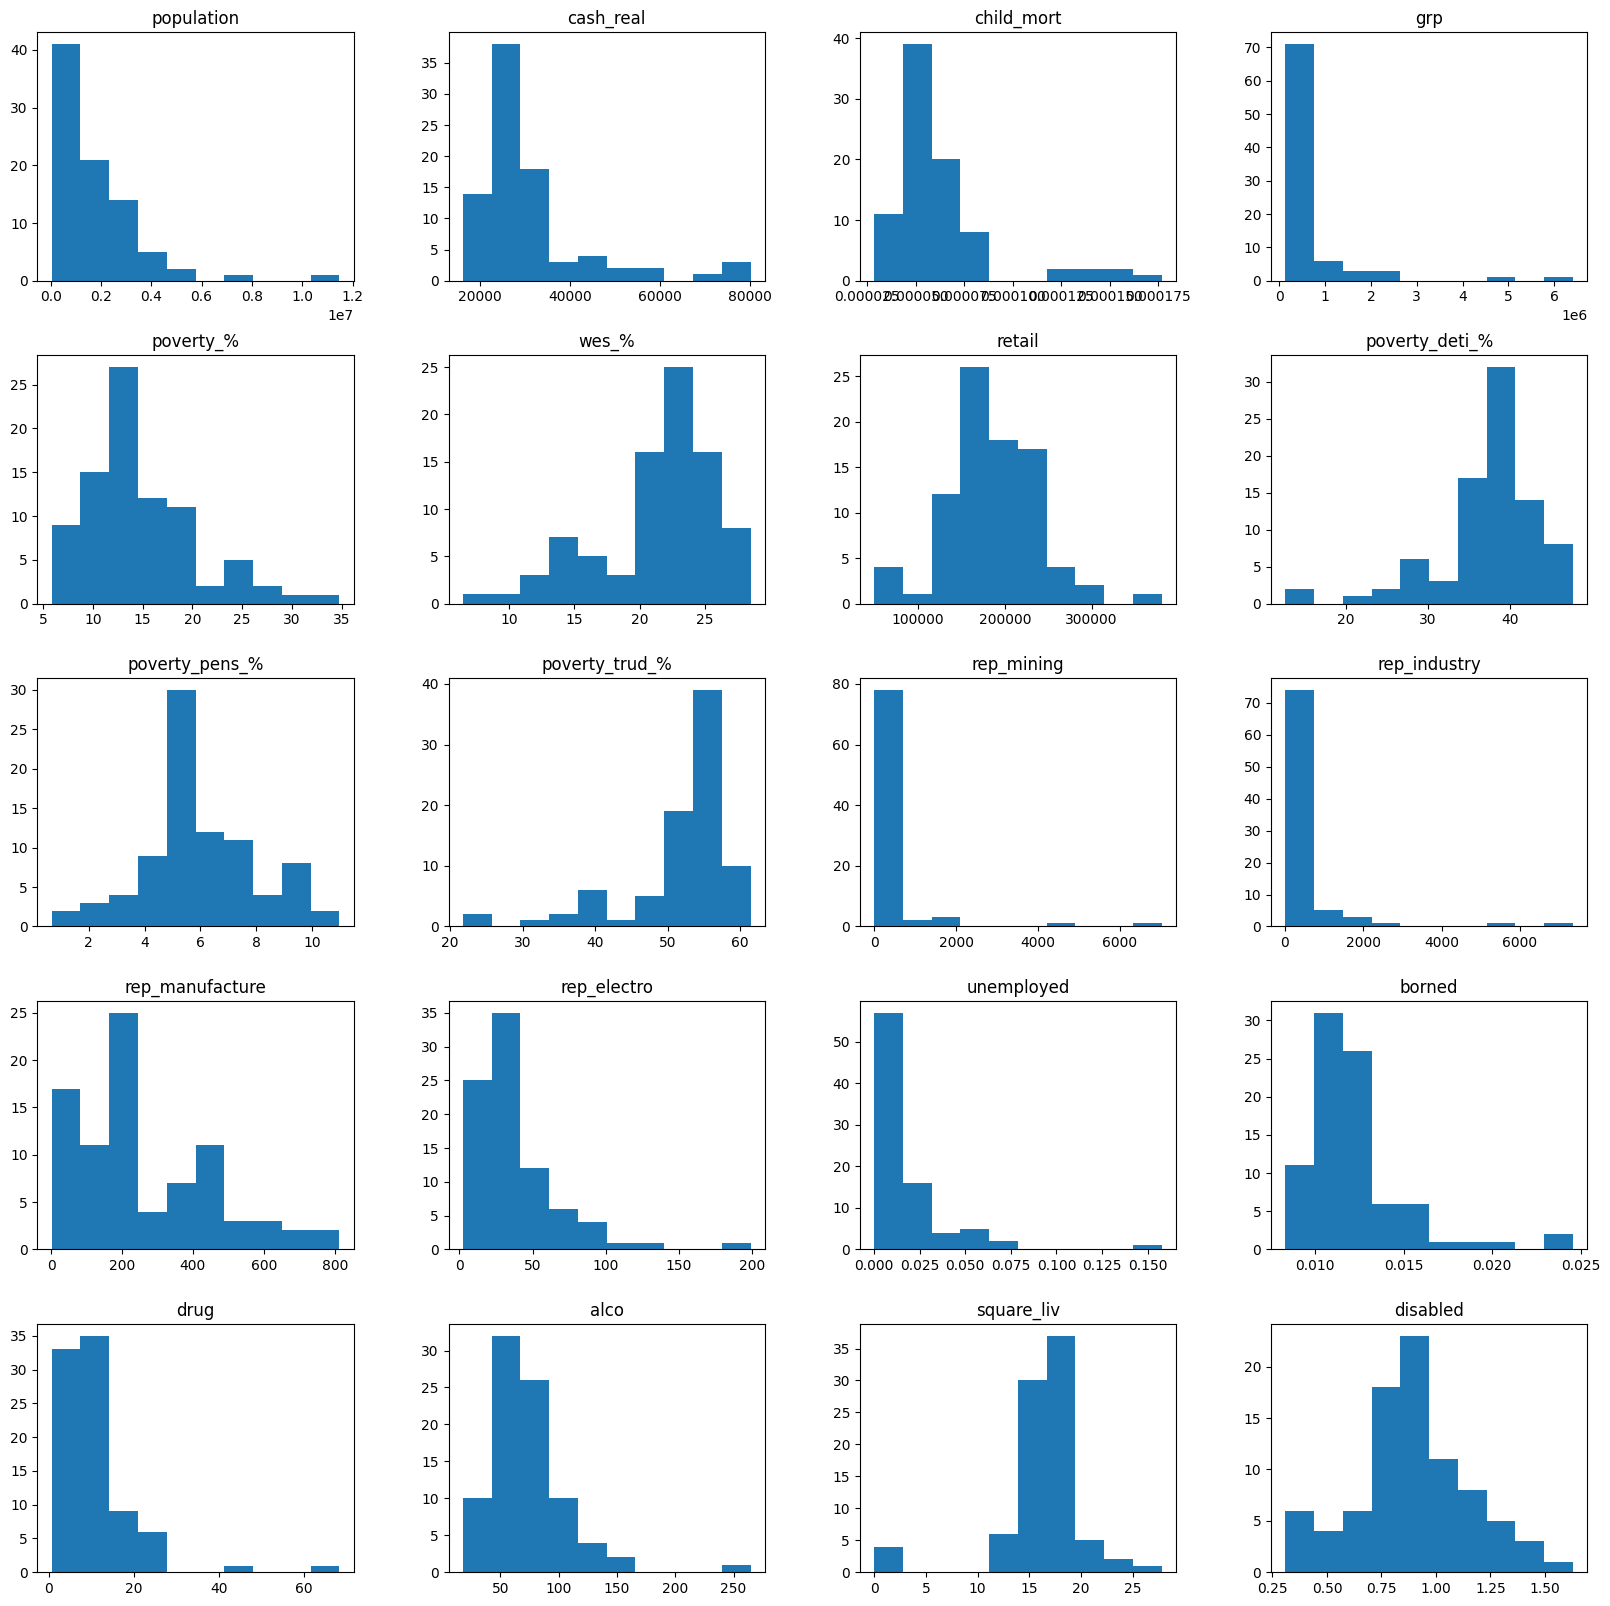

In [32]:
# Визуализируем распределение признаков
Result_regions.hist(figsize = (20,20), grid = False);
plt.show()

Симметричный вид гистограмм наблюдается только у нескольких параметров. Можем утверждать, что существует несколько групп признаков.

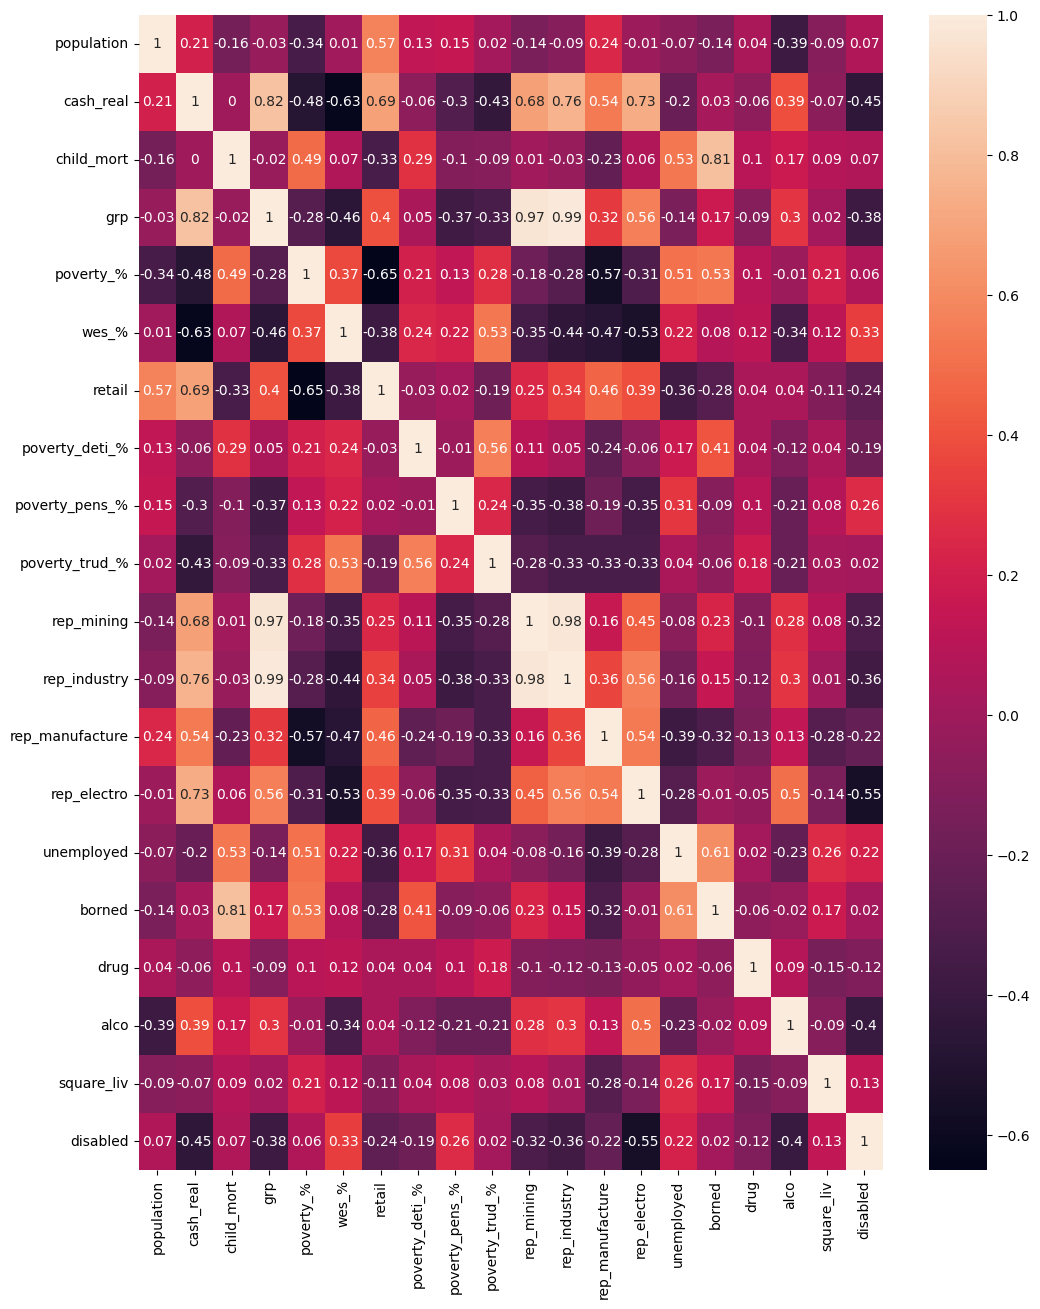

In [33]:
# Создадим тепловую карту, визуализирующую значения матрицы корреляции всех пар переменных
plt.figure(figsize=(12, 15))
sns.heatmap(Result_regions.corr().round(decimals=2), annot=True)
plt.show()

Можем увидеть, что ВРП(grp) имеет большую линейную зависимость от показателей Объем производимой добычи полезных ископаемых на душу населения(rep_mining) и Объем производимой промышленности на душу населения(rep_industry). Коррелиция данных признаков составляет 0,97 и 0,99 соответвенно. Если рассматривать тему детской смертности, то в большей степени она зависит от количества людей за чертой бедности(poverty_%). Коррелиция у данных признаков составляет 0,49. Так же, детская смертность имеет обратную корреляцию (-0,33) с признаком  Оборот розничной торговли на душу населения(retail).
ВПР имеет сильную корреляцию(0,82) с признаком Среднедушевые денежные доходы(cash_income).
Уберем параметры с высокой корреляцией для обучения.

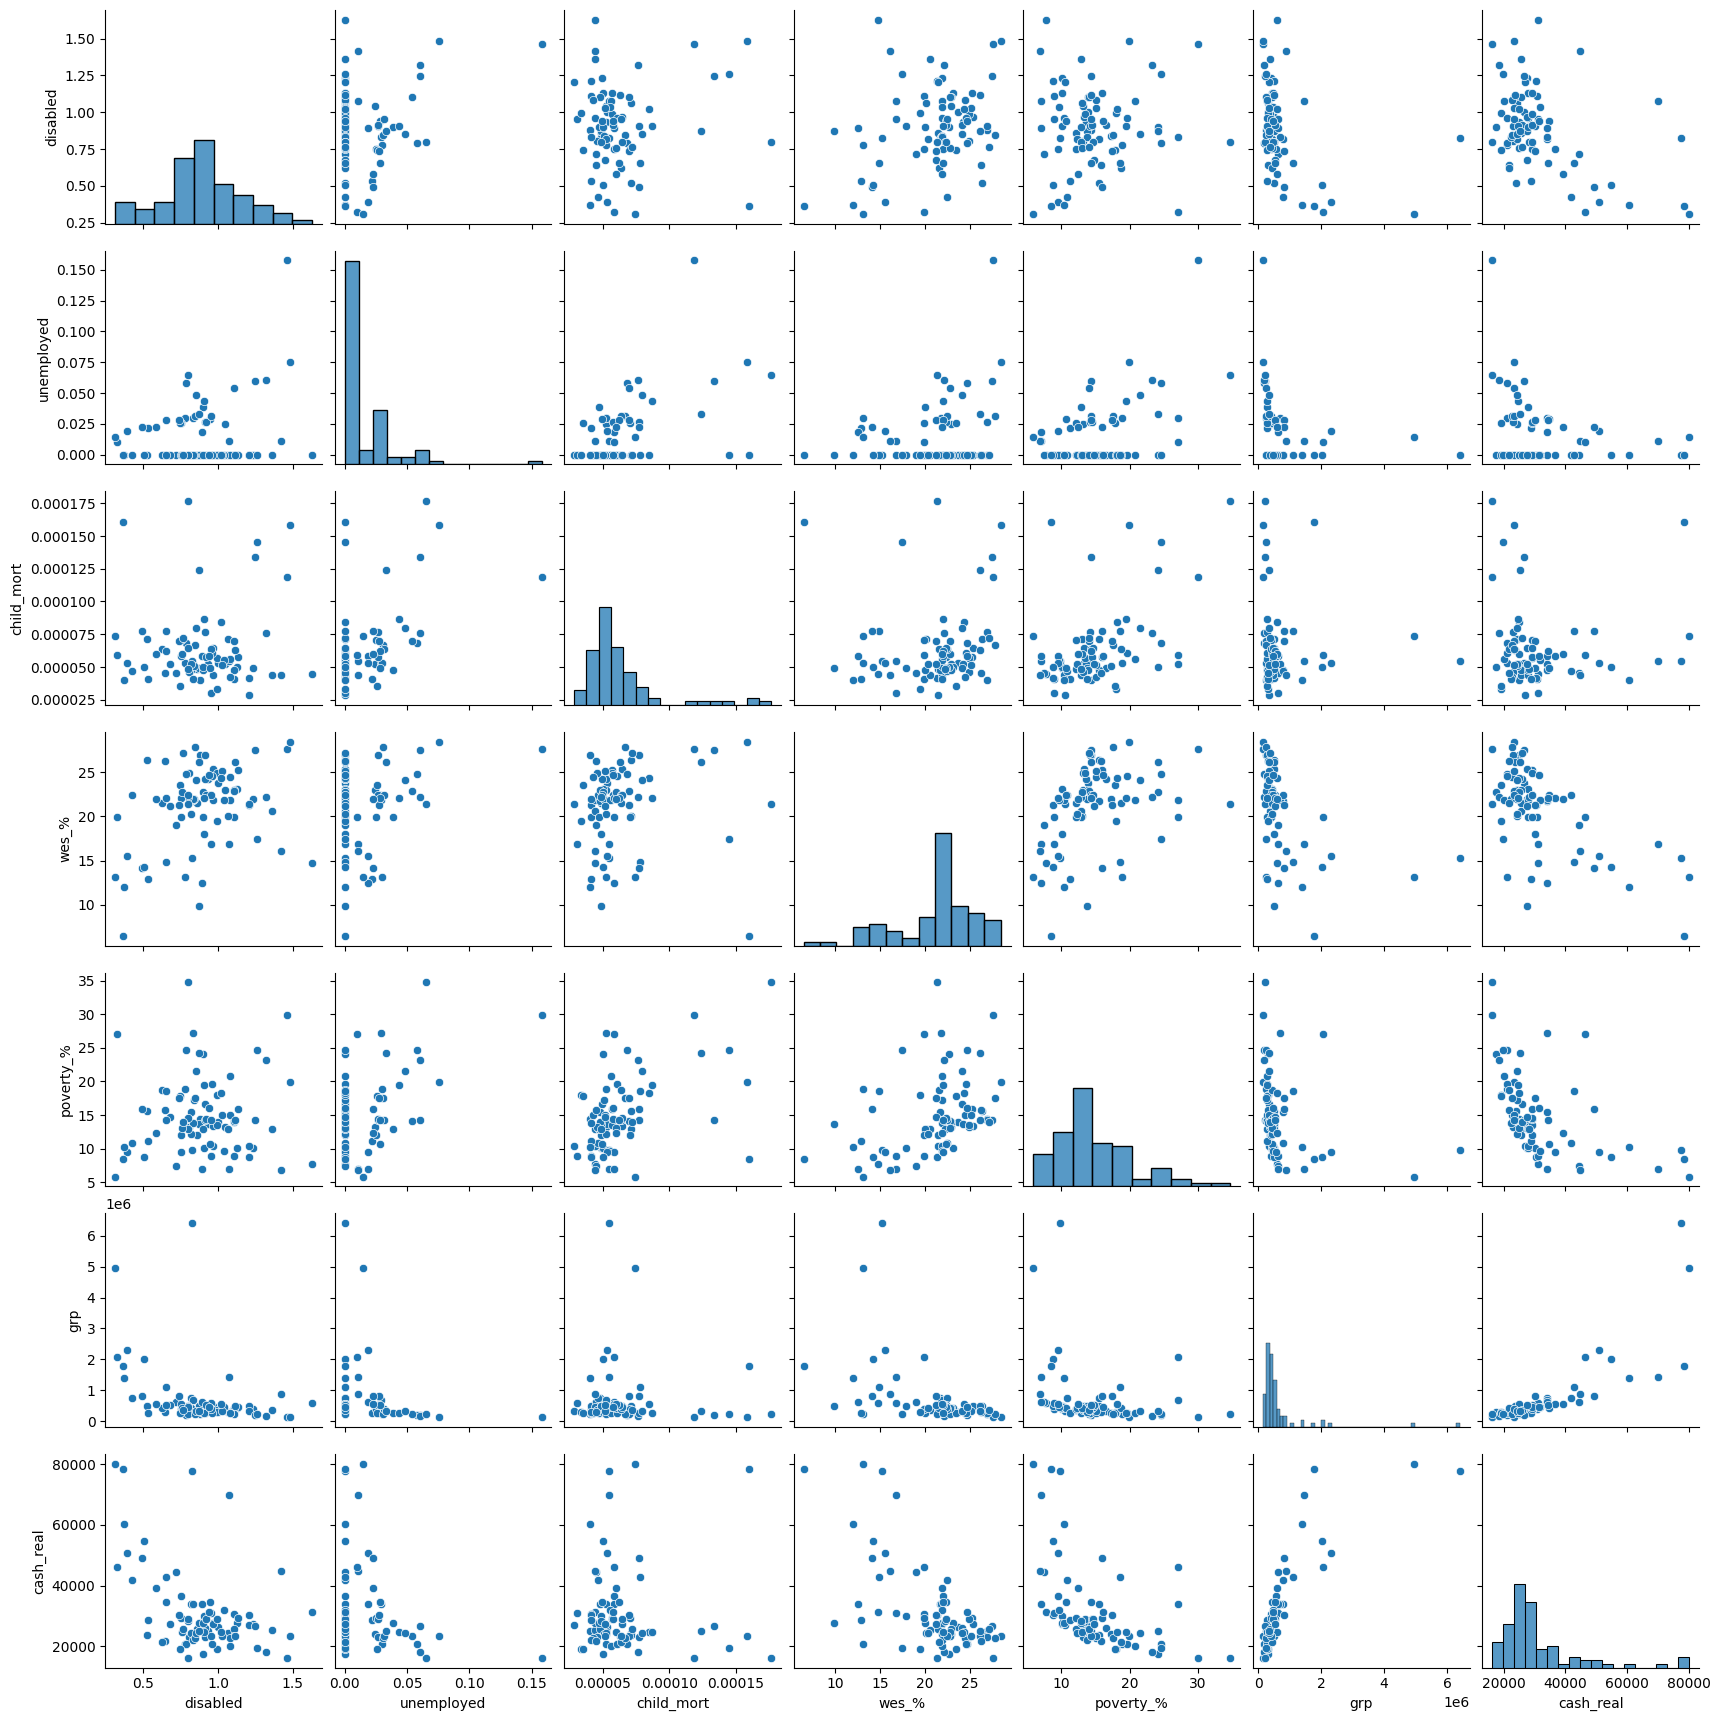

In [34]:
# Создадим матрицу диаграмм разброса для признаков описывающих бедные слои населения, детскую смертность и врп с доходами 
sns.pairplot(Result_regions, vars=['disabled','unemployed','child_mort','wes_%','poverty_%','grp','cash_real'])

Перед кластеризацией выполним стандартизацию признаков. Так как признаки датасета имеют большие различия между своими диапазонами

In [35]:
from sklearn import preprocessing
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

result = s_scaler.fit_transform(Result_regions)

# Преобразуем промежуточный датасет 
result = pd.DataFrame(result, columns=['population','cash_real','child_mort','disabled','grp','poverty_%','wes_%','retail','poverty_deti_%',
'poverty_pens_%','poverty_trud_%','rep_mining','rep_industry','rep_manufacture','rep_electro','unemployed','borned','drug','alco','square_liv'], index=Result_regions.index)
result

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_mining,rep_industry,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv
Регион,,,,,,,,,,,,,,,,,,,,
Белгородская область,-0.130844,0.032309,-0.656123,-0.072480,-1.304604,-1.480065,0.618703,-2.388584,0.113236,-4.073151,-0.183765,-0.000902,1.015135,-0.751955,-0.567410,-0.687624,-0.904263,-0.834235,0.346547,2.782526
Брянская область,-0.273015,-0.323710,-0.348313,-0.380393,-0.159351,0.569803,0.438014,0.634821,-1.026409,0.413341,-0.293079,-0.367874,-0.359525,-0.847560,-0.567410,-0.767376,-0.062771,0.615744,1.822888,0.408573
Владимирская область,-0.177372,-0.504810,-0.368353,-0.320610,-0.291495,0.387996,-0.413356,-1.203472,-0.258388,-1.602181,-0.289554,-0.200871,0.429448,-0.452930,0.441068,-0.782083,-0.011327,-0.108761,-3.824702,0.571969
Воронежская область,0.358999,-0.012347,-0.776628,-0.267135,-1.073351,-0.298323,0.969424,-0.170899,-0.270775,0.906175,-0.289632,-0.316711,-0.273716,0.220880,-0.567410,-0.913049,1.252748,0.270926,-3.824702,0.808698
Ивановская область,-0.399395,-0.438425,-0.807306,-0.461472,-0.078596,1.297028,-0.392049,-1.461615,0.199948,-1.503614,-0.292244,-0.388616,-0.542587,-0.337201,-0.567410,-0.849481,-0.533125,0.268989,0.416849,-0.048219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Амурская область,-0.537670,0.044714,-0.165847,-0.215706,0.229742,0.792516,0.634018,0.138091,-0.159288,0.603677,-0.184177,-0.378888,-1.122326,0.349608,-0.567410,0.097478,1.113112,0.758127,0.229377,0.169672
Магаданская область,-0.942132,2.250675,-0.797340,0.841498,-0.820074,-2.093662,0.803646,-1.586776,0.311435,-1.425441,0.275715,0.725607,2.050278,2.537280,-0.567410,-0.443016,-0.128915,2.311746,-0.590812,-1.982082
Сахалинская область,-0.734281,1.815304,-0.457095,1.557397,-1.117399,-1.589149,2.380663,-1.371656,-0.122126,-1.496817,1.561589,1.320923,-0.699442,-0.085662,-0.567410,0.074267,0.804443,1.374150,0.205943,-1.474721


Cоберём пайплайн из отдельных инструментов, обучим его на обучающей выборке данных

In [36]:
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=2))])
pipe = pipe.fit(result)
table_processed = pipe.transform(result)
rfm_table_processed = pd.DataFrame(data = table_processed, columns = ['axis-1', 'axis-2'])

<Axes: xlabel='axis-1', ylabel='axis-2'>

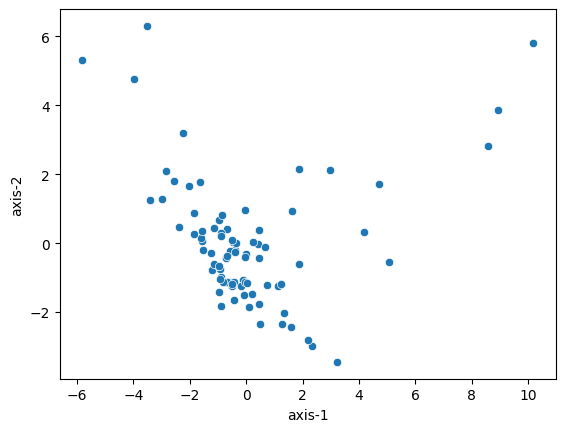

In [37]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2')

**Кластеризация**

Используя метод K-Means найдем необходимое число кластеров с помощью метода локтя.

c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

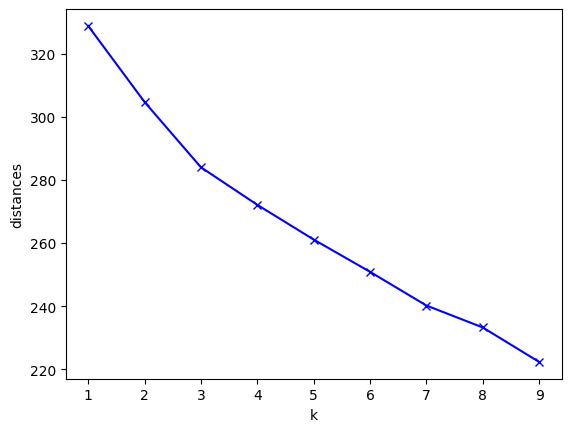

In [38]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
 
# Зададим количество кластеров от 1 до 9
clusters = range(1, 10) 
# Список расстояний между каждым объектом в каждом кластере
distances_sum = []

for k in clusters:
    kmeans_model = KMeans(n_clusters = k).fit(result)
    distances_point = cdist(result, kmeans_model.cluster_centers_, 'euclidean')
     # Извлечем минимальное расстояние от каждого объекта до центра его кластера и сложим их.
    distances_cluster = sum(np.min(distances_point,axis=1))
     # Запишем результаты расстояний диапазона (1, 10) 
    distances_sum.append(distances_cluster)
 
# Визуализируем полученные результаты
plt.plot(clusters, distances_sum, 'bx-')
plt.xlabel('k')
plt.ylabel('distances')
plt.show()

Оптимальным числом кластеров является - 4.

In [39]:
# Исходя из тепловой карты уберем признаки дублирующие ВРП - rep_industry и rep_mining, d_resp дублирует общую заболеваемость
result = result[['population','cash_real','child_mort','disabled','grp','poverty_%','wes_%','retail','poverty_deti_%',
'poverty_pens_%','poverty_trud_%','rep_manufacture','rep_electro','unemployed','borned','drug','alco','square_liv']]
print(result.shape)

(85, 18)


In [40]:
from sklearn.cluster import KMeans
# Используем метод кластеризации KMeans
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(result)

y_kmeans = kmeans.predict(result)

# Pададим индекс для меток
result['labels'] = pd.Series(y_kmeans, index=result.index)
result['labels']

c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\AppData\Local\Temp\ipykernel_8804\2483417033.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['labels'] = pd.Series(y_kmeans, index=result.index)


Регион
Белгородская область            1
Брянская область                3
Владимирская область            3
Воронежская область             3
Ивановская область              3
                               ..
Амурская область                3
Магаданская область             1
Сахалинская область             1
Еврейская автономная область    3
Чукотский автономный округ      2
Name: labels, Length: 85, dtype: int32

In [41]:
# 0 Кластер
result[result['labels']==0].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,-0.436681,-0.787596,2.991378,-0.501943,1.821349,0.735247,-1.428630,0.944593,0.098371,-0.169903,-0.274681,-0.992762,2.358085,3.089162,-0.374381,-0.702604,0.744925,1.341722,0.0
std,0.653456,0.345896,0.795195,0.054244,1.479373,1.104178,1.061647,0.501903,1.054768,0.303495,0.031694,0.175912,2.306888,1.172634,0.357484,0.705235,1.380419,1.046051,0.0
min,-0.914622,-1.105564,1.999517,-0.571639,-0.089608,-0.871013,-2.614547,0.388411,-1.014022,-0.599518,-0.291595,-1.242321,-0.567410,1.752266,-0.771976,-1.323858,-0.637680,-0.373956,0.0
25%,-0.853561,-1.105245,2.532353,-0.546276,0.941854,0.033474,-2.144028,0.404056,-0.766273,-0.246037,-0.290807,-1.111510,1.887040,2.268352,-0.680110,-1.257025,-0.450208,1.329966,0.0
50%,-0.775462,-0.850777,2.941495,-0.474505,1.804464,1.428838,-1.322707,1.260623,0.286660,-0.140673,-0.289508,-0.889657,2.082596,2.829580,-0.367766,-1.038124,0.674623,1.378422,0.0
75%,-0.283639,-0.557407,3.420668,-0.473556,2.784536,1.442474,-1.226368,1.307558,0.348597,-0.110083,-0.283203,-0.888475,2.507574,4.139309,-0.117891,-0.091327,1.447945,2.151306,0.0
max,0.643878,-0.318988,4.062858,-0.443737,3.665500,1.642461,0.164498,1.362315,1.636892,0.246797,-0.218294,-0.831848,5.880624,4.456301,0.065841,0.197313,2.689946,2.222873,0.0


In [42]:
result[result['labels']==0]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Республика Дагестан,0.643878,-0.318988,2.532353,-0.474505,-0.089608,1.428838,0.164498,0.404056,0.286660,0.246797,-0.291595,-1.111510,1.887040,1.752266,-0.117891,-1.038124,1.447945,1.329966,0
Республика Ингушетия,-0.775462,-1.105245,1.999517,-0.571639,2.784536,1.442474,-2.614547,0.388411,1.636892,-0.110083,-0.290807,-1.242321,5.880624,2.829580,-0.680110,-1.323858,2.689946,2.151306,0
Чеченская Республика,-0.283639,-0.557407,3.420668,-0.546276,0.941854,1.642461,-1.322707,1.362315,0.348597,-0.599518,-0.289508,-0.889657,2.507574,4.456301,-0.771976,-1.257025,0.674623,2.222873,0
Республика Алтай,-0.914622,-0.850777,2.941495,-0.443737,1.804464,-0.871013,-1.226368,1.260623,-1.014022,-0.140673,-0.283203,-0.888475,-0.567410,2.268352,-0.367766,-0.091327,-0.450208,1.378422,0
Республика Тыва (Тува),-0.853561,-1.105564,4.062858,-0.473556,3.665500,0.033474,-2.144028,1.307558,-0.766273,-0.246037,-0.218294,-0.831848,2.082596,4.139309,0.065841,0.197313,-0.637680,-0.373956,0


In [43]:
# 1Кластер
result[result['labels']==1].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,0.497639,0.882511,-0.378671,0.375821,-0.646736,-1.117209,1.067201,-0.437299,0.048546,-0.842914,0.146863,0.599948,-0.257730,-0.120846,-0.032762,-0.011472,-0.122132,-0.546806,1.0
std,1.736198,0.882971,0.427040,0.688944,0.930776,0.830752,1.050557,1.669788,1.067002,1.297631,0.712261,1.053817,0.385064,0.677697,0.514912,1.188050,0.332768,1.361559,0.0
min,-0.942132,-0.241838,-1.154498,-0.425201,-1.451431,-2.589084,-0.711478,-3.863130,-1.732494,-4.073151,-0.293343,-0.751955,-0.567410,-1.399004,-0.904263,-1.601359,-0.614246,-2.151024,1.0
25%,-0.532938,0.086037,-0.649651,-0.076364,-1.257802,-1.606193,0.647475,-1.395124,-0.583558,-1.557996,-0.282245,-0.094528,-0.567410,-0.543128,-0.271307,-0.778299,-0.321321,-1.517396,1.0
50%,-0.178199,0.872135,-0.472521,0.066231,-0.915511,-1.234626,0.918938,0.198715,-0.084963,-0.400685,-0.197892,0.328983,-0.567410,-0.326208,-0.101355,-0.333959,-0.133849,-0.787760,1.0
75%,1.176372,1.341510,-0.158240,0.759224,-0.496136,-0.560806,1.390541,0.811805,0.964873,0.032669,0.182388,1.165330,0.117979,0.117446,0.167812,0.265962,0.129783,0.031037,1.0
max,5.777371,2.964687,0.534583,1.864168,2.255958,0.278912,3.808178,1.471831,1.897029,0.637666,1.851203,3.053030,0.362358,1.248103,1.171906,2.311746,0.416849,2.782526,1.0


In [44]:
result[result['labels']==1]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Белгородская область,-0.130844,0.032309,-0.656123,-0.072480,-1.304604,-1.480065,0.618703,-2.388584,0.113236,-4.073151,-0.183765,-0.751955,-0.567410,-0.687624,-0.904263,-0.834235,0.346547,2.782526,1
Калужская область,-0.431062,-0.053207,-0.487947,-0.170454,-0.856780,-0.748294,0.224824,-1.402946,1.005132,-1.775523,-0.289068,-0.544190,-0.567410,-0.587774,-0.364092,-0.374155,-0.192434,0.041986,1
Московская область,3.152102,1.041482,-0.630234,-0.022730,-1.352323,-0.498310,2.381399,1.209776,0.844095,-0.606316,-0.291362,-0.097484,-0.567410,-0.416803,0.179755,-0.884602,-0.356472,-0.667522,1
г. Москва,5.777371,2.964687,-0.289535,0.888680,-1.429407,-1.002823,3.808178,0.364944,1.897029,-0.150869,-0.166562,0.836818,-0.133323,-0.589328,-0.121566,-1.465756,-0.590812,0.687460,1
Калининградская область,-0.465666,-0.241838,-0.493327,-0.179836,-0.199728,-2.589084,-0.292275,-0.495534,1.711217,0.637666,-0.274532,0.018048,-0.567410,-0.382667,-0.540474,0.258334,-0.169000,-0.077951,1
Ленинградская область,-0.001956,0.015242,-1.154498,-0.040513,-1.077021,-1.002823,0.733792,-3.863130,-0.047801,-2.744197,-0.284816,1.261697,-0.567410,-1.399004,-0.173010,-1.036671,0.159075,0.224223,1
Мурманская область,-0.554662,0.832141,-0.572382,0.140961,-0.735648,0.278912,0.807050,0.474459,-1.051184,0.545896,-0.097592,1.225577,-0.567410,-0.551244,-0.272226,-0.293762,0.323113,-1.787099,1
г. Санкт-Петербург,1.916672,1.056530,-0.660503,0.265790,-1.451431,-1.166449,1.503374,-3.792727,-1.732494,-2.343132,-0.287487,-0.018414,-0.112279,-0.269748,-0.048073,-1.601359,-0.145566,1.984296,1
г. Севастополь,-0.771085,-0.160391,-0.768680,-0.425201,-0.658564,-1.902765,-0.711478,-0.972708,-1.100734,-1.578389,-0.293343,-0.594356,0.323133,-0.518780,1.171906,0.268505,-0.614246,-1.364623,1


In [45]:
# 2 Кластер
result[result['labels']==2].describe()


,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,-0.915861,3.641169,1.195404,4.201486,-1.234861,-2.189110,0.688669,-0.163077,-2.310575,-1.945466,4.077569,2.957482,-0.368412,0.851941,-0.790349,2.507078,0.120019,-1.495120,2.0
std,0.164044,0.097971,2.008653,2.659918,0.371284,1.040425,0.562811,1.817491,0.372929,1.798689,3.313730,1.980642,0.344675,0.460569,0.512384,2.766094,0.841451,1.063375,0.0
min,-1.013524,3.554812,-0.292453,1.277519,-1.638636,-3.357216,0.144148,-2.009192,-2.612003,-3.655091,0.626990,1.663637,-0.567410,0.340669,-1.091669,0.191502,-0.520510,-2.211403,2.0
25%,-1.010556,3.587936,0.052986,3.063378,-1.398206,-2.602720,0.398933,-1.056800,-2.519097,-2.883551,2.498870,1.817410,-0.567410,0.660732,-1.086157,0.975576,-0.356472,-2.106039,2.0
50%,-1.007587,3.621060,0.398424,4.849237,-1.157776,-1.848223,0.653717,-0.104408,-2.426191,-2.112010,4.370750,1.971182,-0.567410,0.980795,-1.080645,1.759649,-0.192434,-2.000675,2.0
75%,-0.867029,3.684347,1.939333,5.663470,-1.032973,-1.605057,0.960930,0.759981,-2.159861,-1.090653,5.802859,3.604405,-0.268913,1.107578,-0.639689,3.664867,0.440283,-1.136979,2.0
max,-0.726470,3.747634,3.480241,6.477703,-0.908170,-1.361891,1.268142,1.624370,-1.893531,-0.069297,7.234968,5.237627,0.029585,1.234360,-0.198733,5.570084,1.073001,-0.273283,2.0


In [46]:
result[result['labels']==2]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Ненецкий автономный округ,-1.013524,3.554812,-0.292453,6.477703,-0.908170,-1.361891,0.653717,-0.104408,-1.893531,-2.112010,7.234968,1.663637,-0.567410,1.234360,-1.080645,1.759649,1.073001,-0.273283,2
Ямало-Ненецкий автономный округ,-0.726470,3.747634,0.398424,4.849237,-1.638636,-1.848223,1.268142,1.624370,-2.426191,-0.069297,4.370750,1.971182,0.029585,0.980795,-0.198733,0.191502,-0.192434,-2.211403,2
Чукотский автономный округ,-1.007587,3.621060,3.480241,1.277519,-1.157776,-3.357216,0.144148,-2.009192,-2.612003,-3.655091,0.626990,5.237627,-0.567410,0.340669,-1.091669,5.570084,-0.520510,-2.000675,2


In [47]:
# 3 Кластер
result[result['labels']==3].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,-0.068246,-0.387639,-0.198763,-0.285755,0.105747,0.389845,-0.239533,0.061655,0.094340,0.370481,-0.228862,-0.249283,-0.102475,-0.268244,0.081910,-0.064436,-0.031971,0.129140,3.0
std,0.640466,0.307606,0.547100,0.143342,0.741533,0.552619,0.664134,0.612781,0.873806,0.543767,0.107840,0.538806,0.730252,0.539278,1.148211,0.617856,1.105883,0.653546,0.0
min,-0.934290,-1.011651,-1.221568,-0.512719,-1.110058,-1.839132,-2.073221,-1.923144,-1.980243,-1.602181,-0.293343,-1.102521,-0.567410,-1.224943,-0.988780,-1.184865,-3.824702,-1.411422,3.0
25%,-0.506961,-0.577116,-0.524624,-0.385144,-0.326367,0.115287,-0.636250,-0.303882,-0.413231,0.238300,-0.292116,-0.632424,-0.567410,-0.709839,-0.534962,-0.498135,-0.040113,-0.310540,3.0
50%,-0.288236,-0.438425,-0.357946,-0.312103,-0.085937,0.269822,-0.265093,0.220227,-0.159288,0.430335,-0.286944,-0.279249,-0.567410,-0.253147,-0.264876,-0.111667,0.182509,0.067838,3.0
75%,0.389102,-0.206725,0.061306,-0.214417,0.501372,0.781153,0.181289,0.441213,0.546797,0.639365,-0.194770,-0.106923,0.516222,0.093643,0.185266,0.354225,0.428566,0.558692,3.0
max,2.125412,0.290907,2.177751,0.184543,2.266970,1.492470,1.167764,1.025947,2.491626,1.317437,0.169934,1.869806,1.902887,1.277669,6.375190,1.397397,1.822888,1.765799,3.0


In [48]:
# 3 Кластер
result[result['labels']==3]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Брянская область,-0.273015,-0.323710,-0.348313,-0.380393,-0.159351,0.569803,0.438014,0.634821,-1.026409,0.413341,-0.293079,-0.847560,-0.567410,-0.767376,-0.062771,0.615744,1.822888,0.408573,3
Владимирская область,-0.177372,-0.504810,-0.368353,-0.320610,-0.291495,0.387996,-0.413356,-1.203472,-0.258388,-1.602181,-0.289554,-0.452930,0.441068,-0.782083,-0.011327,-0.108761,-3.824702,0.571969,3
Воронежская область,0.358999,-0.012347,-0.776628,-0.267135,-1.073351,-0.298323,0.969424,-0.170899,-0.270775,0.906175,-0.289632,0.220880,-0.567410,-0.913049,1.252748,0.270926,-3.824702,0.808698,3
Ивановская область,-0.399395,-0.438425,-0.807306,-0.461472,-0.078596,1.297028,-0.392049,-1.461615,0.199948,-1.503614,-0.292244,-0.337201,-0.567410,-0.849481,-0.533125,0.268989,0.416849,-0.048219,3
Костромская область,-0.633236,-0.484919,0.310650,-0.389895,-0.331873,-0.261962,-0.448916,0.795182,-0.258388,0.056461,-0.292128,0.608093,-0.567410,-0.406875,-0.191384,-0.111667,-0.426774,0.640004,3
Курская область,-0.349254,-0.247608,-0.480137,-0.263926,-0.860451,0.160738,0.117342,0.122445,0.534409,0.426936,-0.204200,0.429487,-0.567410,-0.682996,-0.536799,-0.246301,0.182509,1.286085,3
Липецкая область,-0.338922,-0.036125,-0.764228,-0.170178,-1.110058,0.019838,0.704759,0.333654,-0.122126,0.426936,-0.286944,-0.609651,-0.567410,-0.699659,-0.301623,0.054930,0.041905,1.196077,3
Орловская область,-0.564941,-0.443330,-0.361909,-0.342342,-0.214411,0.674341,-0.142776,0.235872,0.385760,0.365757,-0.293024,-0.722503,-0.567410,-0.832929,-0.713182,0.649645,0.580887,0.151204,3
Рязанская область,-0.343760,-0.398947,-0.660538,-0.306223,-0.342885,-0.139242,-0.207947,-0.425131,0.559184,0.899378,-0.291779,-0.169180,-0.567410,-0.895039,1.091064,-0.430333,0.627755,1.765799,3


Самый большой кластер - 3. Туда относятся регионы с наименьшей детской смертностью, и самой высокой рождаемостью.
Расходы на соц политику миимальны в 0 кластере, максимальны в 3 и 1 кластере.
В 0 кластер попали регионы с самым большим показателем детской смертности, самой большой безработицей и самой маленькой площадью на душу населения.


Используя метод главных компонент, чтобы найти зависимость доли объясненной дисперсии от числа показателей социально-экономического развития регионов:

In [49]:
# Применение метода главных компонент Principal Component Analysis
from sklearn.decomposition import PCA 

# Скопируем признаки без меток
result_pca = result.drop(['labels'], axis=1)
result_pca

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv
Регион,,,,,,,,,,,,,,,,,,
Белгородская область,-0.130844,0.032309,-0.656123,-0.072480,-1.304604,-1.480065,0.618703,-2.388584,0.113236,-4.073151,-0.183765,-0.751955,-0.567410,-0.687624,-0.904263,-0.834235,0.346547,2.782526
Брянская область,-0.273015,-0.323710,-0.348313,-0.380393,-0.159351,0.569803,0.438014,0.634821,-1.026409,0.413341,-0.293079,-0.847560,-0.567410,-0.767376,-0.062771,0.615744,1.822888,0.408573
Владимирская область,-0.177372,-0.504810,-0.368353,-0.320610,-0.291495,0.387996,-0.413356,-1.203472,-0.258388,-1.602181,-0.289554,-0.452930,0.441068,-0.782083,-0.011327,-0.108761,-3.824702,0.571969
Воронежская область,0.358999,-0.012347,-0.776628,-0.267135,-1.073351,-0.298323,0.969424,-0.170899,-0.270775,0.906175,-0.289632,0.220880,-0.567410,-0.913049,1.252748,0.270926,-3.824702,0.808698
Ивановская область,-0.399395,-0.438425,-0.807306,-0.461472,-0.078596,1.297028,-0.392049,-1.461615,0.199948,-1.503614,-0.292244,-0.337201,-0.567410,-0.849481,-0.533125,0.268989,0.416849,-0.048219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Амурская область,-0.537670,0.044714,-0.165847,-0.215706,0.229742,0.792516,0.634018,0.138091,-0.159288,0.603677,-0.184177,0.349608,-0.567410,0.097478,1.113112,0.758127,0.229377,0.169672
Магаданская область,-0.942132,2.250675,-0.797340,0.841498,-0.820074,-2.093662,0.803646,-1.586776,0.311435,-1.425441,0.275715,2.537280,-0.567410,-0.443016,-0.128915,2.311746,-0.590812,-1.982082
Сахалинская область,-0.734281,1.815304,-0.457095,1.557397,-1.117399,-1.589149,2.380663,-1.371656,-0.122126,-1.496817,1.561589,-0.085662,-0.567410,0.074267,0.804443,1.374150,0.205943,-1.474721


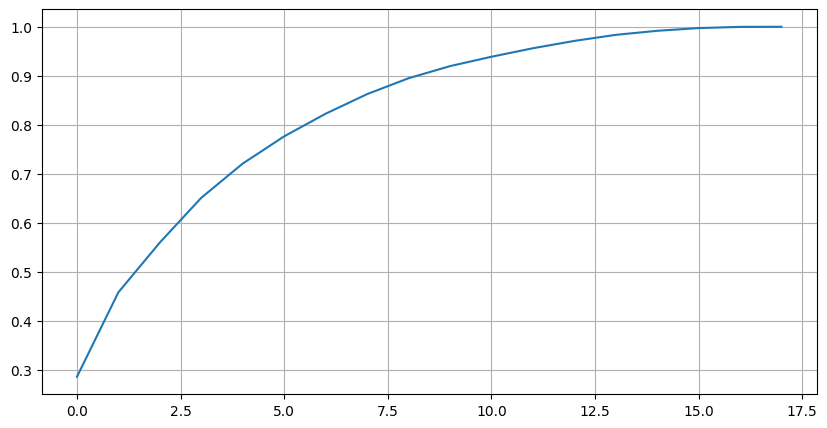

In [50]:
# Передадим признаки в метод
pca = PCA().fit(result_pca)
# Построим график зависимости доли объясненной дисперсии от числа индикаторов
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.gcf().set_size_inches(10,5)
plt.grid(True)

Из графика видим, что 90% объясненной дисперсии зависит всего от 10 признаков. Вероятнее всего, это показатели - ВРП, объемов производства, среднедушевых доходов населения, потребления и бедности.

Проверим, насколько сильную корреляцию имеет признак ВРП с другими экономическими признаками и исключим их из выборки. Будем считать это проверкой гепотезы о том, что благополучие региона не зависит от показателей ВРП

In [51]:
# Понизим размерность признаков и оставим признаки связанные с социально-незащщенными слоями населения
result_gip = result[['population','child_mort','disabled','wes_%','poverty_deti_%',
'poverty_pens_%','poverty_trud_%','unemployed','borned','drug','alco','square_liv']]
print(result_gip.shape)

(85, 12)


In [52]:
# Снова выполним кластеризацию с новым набором признаков
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(result_gip)

y_kmeans = kmeans.predict(result_gip)

# Pададим индекс для меток
result_gip['labels'] = pd.Series(y_kmeans, index=result.index)
result_gip['labels']

c:\Users\PC\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\AppData\Local\Temp\ipykernel_8804\1232731284.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_gip['labels'] = pd.Series(y_kmeans, index=result.index)


Регион
Белгородская область            0
Брянская область                1
Владимирская область            1
Воронежская область             1
Ивановская область              1
                               ..
Амурская область                1
Магаданская область             1
Сахалинская область             0
Еврейская автономная область    1
Чукотский автономный округ      3
Name: labels, Length: 85, dtype: int32

In [53]:
# 0 Кластер
result[result_gip['labels']==0].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,1.436624,0.796671,-0.388340,0.393359,-0.793814,-0.719275,1.433859,-0.334270,0.076074,-0.880839,0.186306,0.399119,-0.180117,-0.107506,-0.066729,-0.629975,0.032892,-0.079854,1.461538
std,1.693497,0.917549,0.347147,0.792862,0.990049,0.829631,0.928226,1.876469,0.960740,1.377033,0.817044,1.058731,0.430568,0.677693,0.432012,0.732710,0.366742,1.405826,0.877058
min,-0.734281,-0.126242,-1.154498,-0.312103,-1.451431,-1.989123,0.608834,-3.863130,-1.732494,-4.073151,-0.291362,-0.751955,-0.567410,-1.399004,-0.904263,-1.601359,-0.590812,-2.151024,1.000000
25%,-0.001956,0.032309,-0.630234,-0.105897,-1.352323,-1.302804,0.733792,-1.371656,-0.481362,-1.496817,-0.284816,-0.138757,-0.567410,-0.589328,-0.173010,-0.937390,-0.145566,-0.667522,1.000000
50%,1.379490,0.442565,-0.337979,-0.022730,-1.077021,-1.002823,1.223906,0.478370,-0.122126,-0.171262,-0.222628,-0.085662,-0.156972,-0.068866,-0.077470,-0.741735,0.159075,-0.001809,1.000000
75%,1.916672,1.175724,-0.163556,0.888680,-0.746660,-0.298323,1.503374,0.861674,0.844095,-0.086291,-0.121291,0.836818,0.194731,0.140329,0.131984,-0.465203,0.346547,0.366966,1.000000
max,5.777371,2.964687,0.266623,1.864168,2.255958,0.842512,3.808178,1.471831,1.897029,0.403144,1.851203,3.053030,0.597414,1.065346,0.804443,1.374150,0.440283,2.782526,3.000000


In [54]:
# 0 Кластер
result[result_gip['labels']==0]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Белгородская область,-0.130844,0.032309,-0.656123,-0.072480,-1.304604,-1.480065,0.618703,-2.388584,0.113236,-4.073151,-0.183765,-0.751955,-0.567410,-0.687624,-0.904263,-0.834235,0.346547,2.782526,1
Московская область,3.152102,1.041482,-0.630234,-0.022730,-1.352323,-0.498310,2.381399,1.209776,0.844095,-0.606316,-0.291362,-0.097484,-0.567410,-0.416803,0.179755,-0.884602,-0.356472,-0.667522,1
г. Москва,5.777371,2.964687,-0.289535,0.888680,-1.429407,-1.002823,3.808178,0.364944,1.897029,-0.150869,-0.166562,0.836818,-0.133323,-0.589328,-0.121566,-1.465756,-0.590812,0.687460,1
Ленинградская область,-0.001956,0.015242,-1.154498,-0.040513,-1.077021,-1.002823,0.733792,-3.863130,-0.047801,-2.744197,-0.284816,1.261697,-0.567410,-1.399004,-0.173010,-1.036671,0.159075,0.224223,1
г. Санкт-Петербург,1.916672,1.056530,-0.660503,0.265790,-1.451431,-1.166449,1.503374,-3.792727,-1.732494,-2.343132,-0.287487,-0.018414,-0.112279,-0.269748,-0.048073,-1.601359,-0.145566,1.984296,1
Краснодарский край,2.125412,0.290907,-0.470852,-0.228429,-0.746660,0.260732,1.167764,0.556596,1.029907,-0.086291,-0.284075,-0.644342,0.597414,-0.068866,-0.525775,-0.937390,0.416849,0.184896,3
Ростовская область,1.514384,-0.126242,-0.197443,-0.312103,-0.232764,0.842512,0.669152,0.478370,-0.506137,0.403144,-0.284986,-0.117869,-0.567410,-0.610419,-0.077470,-0.741735,0.440283,0.366966,3
Республика Башкортостан,1.379490,-0.119713,0.266623,-0.269565,-0.493383,-0.298323,0.608834,0.435346,-0.221225,0.365757,-0.222628,-0.243177,0.474768,0.218176,-0.525775,-0.290856,0.252811,-0.536937,3
Республика Татарстан (Татарстан),1.230121,0.247223,-0.156468,-0.008498,-1.422066,-1.989123,0.854900,0.576152,1.277656,-0.171262,-0.121291,-0.138757,0.194731,0.128237,-0.081145,-0.610491,-0.028396,-0.001809,1


In [55]:
# 1 Кластер
result[result_gip['labels']==1].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,-0.214767,-0.270973,-0.210855,-0.237631,0.076835,0.191276,-0.211922,0.001746,0.085171,0.283388,-0.207520,-0.142143,-0.130370,-0.259438,0.079850,0.065335,-0.070504,-0.018518,2.750000
std,0.497144,0.542970,0.550909,0.234069,0.739765,0.831446,0.670104,0.680084,0.913664,0.674729,0.157324,0.679022,0.707458,0.552258,1.117561,0.740105,1.063072,0.785113,0.666667
min,-0.942132,-1.011651,-1.221568,-0.512719,-1.110058,-2.589084,-2.073221,-1.923144,-1.980243,-1.775523,-0.293343,-1.102521,-0.567410,-1.224943,-0.988780,-1.184865,-3.824702,-1.982082,1.000000
25%,-0.542720,-0.563184,-0.540585,-0.382768,-0.340132,0.040292,-0.634249,-0.371351,-0.447296,0.166074,-0.292110,-0.600376,-0.567410,-0.687162,-0.537718,-0.438203,-0.151425,-0.409095,3.000000
50%,-0.346507,-0.393458,-0.364065,-0.285729,-0.089608,0.244824,-0.236520,0.126357,-0.159288,0.437133,-0.286746,-0.271277,-0.567410,-0.322158,-0.266714,-0.079219,0.135641,0.017030,3.000000
75%,0.105248,-0.128957,0.057125,-0.170385,0.497701,0.722066,0.206000,0.435346,0.559184,0.635116,-0.180271,0.079991,0.450810,0.086257,0.287238,0.439219,0.375840,0.516026,3.000000
max,1.053146,2.250675,2.177751,0.841498,2.266970,1.492470,1.213530,1.233244,2.491626,1.317437,0.569756,2.537280,1.902887,1.277669,6.375190,2.311746,1.822888,1.765799,3.000000


In [56]:
# 1 Кластер
result[result_gip['labels']==1]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Брянская область,-0.273015,-0.323710,-0.348313,-0.380393,-0.159351,0.569803,0.438014,0.634821,-1.026409,0.413341,-0.293079,-0.847560,-0.567410,-0.767376,-0.062771,0.615744,1.822888,0.408573,3
Владимирская область,-0.177372,-0.504810,-0.368353,-0.320610,-0.291495,0.387996,-0.413356,-1.203472,-0.258388,-1.602181,-0.289554,-0.452930,0.441068,-0.782083,-0.011327,-0.108761,-3.824702,0.571969,3
Воронежская область,0.358999,-0.012347,-0.776628,-0.267135,-1.073351,-0.298323,0.969424,-0.170899,-0.270775,0.906175,-0.289632,0.220880,-0.567410,-0.913049,1.252748,0.270926,-3.824702,0.808698,3
Ивановская область,-0.399395,-0.438425,-0.807306,-0.461472,-0.078596,1.297028,-0.392049,-1.461615,0.199948,-1.503614,-0.292244,-0.337201,-0.567410,-0.849481,-0.533125,0.268989,0.416849,-0.048219,3
Калужская область,-0.431062,-0.053207,-0.487947,-0.170454,-0.856780,-0.748294,0.224824,-1.402946,1.005132,-1.775523,-0.289068,-0.544190,-0.567410,-0.587774,-0.364092,-0.374155,-0.192434,0.041986,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Приморский край,0.139408,0.278715,-0.007464,-0.145235,-0.085937,0.188009,0.531862,0.662200,-0.196450,0.158427,-0.280727,-0.178106,0.591971,-0.308544,3.453855,-0.009965,-0.145566,-0.909169,3
Хабаровский край,-0.225553,0.637148,-0.107123,-0.077658,-0.441993,0.165283,1.213530,0.032486,1.029907,0.372555,-0.249048,0.110350,0.358702,0.085073,0.378185,1.789676,-0.215868,-1.180093,1
Амурская область,-0.537670,0.044714,-0.165847,-0.215706,0.229742,0.792516,0.634018,0.138091,-0.159288,0.603677,-0.184177,0.349608,-0.567410,0.097478,1.113112,0.758127,0.229377,0.169672,3


In [57]:
# 2 Кластер
result[result_gip['labels']==2].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0
mean,-0.869997,3.651223,0.052986,5.663470,-1.273403,-1.605057,0.960930,0.759981,-2.159861,-1.090653,5.802859,1.817410,-0.268913,1.107578,-0.639689,0.975576,0.440283,-1.242343,2.0
std,0.202978,0.136345,0.488524,1.151500,0.516517,0.343889,0.434464,1.222430,0.376648,1.444416,2.025308,0.217468,0.422139,0.179298,0.623606,1.108848,0.894798,1.370458,0.0
min,-1.013524,3.554812,-0.292453,4.849237,-1.638636,-1.848223,0.653717,-0.104408,-2.426191,-2.112010,4.370750,1.663637,-0.567410,0.980795,-1.080645,0.191502,-0.192434,-2.211403,2.0
25%,-0.941761,3.603018,-0.119733,5.256353,-1.456019,-1.726640,0.807323,0.327787,-2.293026,-1.601332,5.086804,1.740523,-0.418161,1.044186,-0.860167,0.583539,0.123924,-1.726873,2.0
50%,-0.869997,3.651223,0.052986,5.663470,-1.273403,-1.605057,0.960930,0.759981,-2.159861,-1.090653,5.802859,1.817410,-0.268913,1.107578,-0.639689,0.975576,0.440283,-1.242343,2.0
75%,-0.798234,3.699428,0.225705,6.070587,-1.090786,-1.483474,1.114536,1.192176,-2.026696,-0.579975,6.518913,1.894296,-0.119664,1.170969,-0.419211,1.367612,0.756642,-0.757813,2.0
max,-0.726470,3.747634,0.398424,6.477703,-0.908170,-1.361891,1.268142,1.624370,-1.893531,-0.069297,7.234968,1.971182,0.029585,1.234360,-0.198733,1.759649,1.073001,-0.273283,2.0


In [58]:
# 2 Кластер
result[result_gip['labels']==2]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Ненецкий автономный округ,-1.013524,3.554812,-0.292453,6.477703,-0.908170,-1.361891,0.653717,-0.104408,-1.893531,-2.112010,7.234968,1.663637,-0.567410,1.234360,-1.080645,1.759649,1.073001,-0.273283,2
Ямало-Ненецкий автономный округ,-0.726470,3.747634,0.398424,4.849237,-1.638636,-1.848223,1.268142,1.624370,-2.426191,-0.069297,4.370750,1.971182,0.029585,0.980795,-0.198733,0.191502,-0.192434,-2.211403,2


In [59]:
# 3 Кластер
result[result_gip['labels']==3].describe()

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,-0.531832,-0.052820,3.072855,-0.205366,1.324828,0.053169,-1.166501,0.452295,-0.353358,-0.750768,-0.124403,0.045636,1.870503,2.631079,-0.493929,0.342844,0.534019,0.784656,0.333333
std,0.629227,1.826223,0.738714,0.728080,1.797229,1.940810,1.146276,1.286727,1.454092,1.448486,0.369196,2.548407,2.384073,1.535934,0.433574,2.637357,1.338407,1.654483,0.816497
min,-1.007587,-1.105564,1.999517,-0.571639,-1.157776,-3.357216,-2.614547,-2.009192,-2.612003,-3.655091,-0.291595,-1.242321,-0.567410,0.340669,-1.091669,-1.323858,-0.637680,-2.000675,0.000000
25%,-0.899356,-1.041628,2.634639,-0.528333,0.168258,-0.644891,-1.938698,0.392323,-0.952085,-0.511148,-0.290482,-1.056047,0.046203,1.881287,-0.749010,-1.202300,-0.502935,0.052025,0.000000
50%,-0.814511,-0.704092,3.181082,-0.474030,1.373159,0.731156,-1.274538,0.832339,-0.239806,-0.193355,-0.286355,-0.889066,1.984818,2.548966,-0.523938,-0.564725,0.112207,1.354194,0.000000
75%,-0.406595,-0.378593,3.465348,-0.451192,2.539518,1.439065,-0.198481,1.295824,0.333113,-0.117730,-0.234521,-0.846005,2.401330,3.811877,-0.180360,0.125153,1.254614,1.958085,0.000000
max,0.643878,3.621060,4.062858,1.277519,3.665500,1.642461,0.164498,1.362315,1.636892,0.246797,0.626990,5.237627,5.880624,4.456301,0.065841,5.570084,2.689946,2.222873,2.000000


In [60]:
# 3 Кластер
result[result_gip['labels']==3]

,population,cash_real,child_mort,disabled,grp,poverty_%,wes_%,retail,poverty_deti_%,poverty_pens_%,poverty_trud_%,rep_manufacture,rep_electro,unemployed,borned,drug,alco,square_liv,labels
Регион,,,,,,,,,,,,,,,,,,,
Республика Дагестан,0.643878,-0.318988,2.532353,-0.474505,-0.089608,1.428838,0.164498,0.404056,0.286660,0.246797,-0.291595,-1.111510,1.887040,1.752266,-0.117891,-1.038124,1.447945,1.329966,0
Республика Ингушетия,-0.775462,-1.105245,1.999517,-0.571639,2.784536,1.442474,-2.614547,0.388411,1.636892,-0.110083,-0.290807,-1.242321,5.880624,2.829580,-0.680110,-1.323858,2.689946,2.151306,0
Чеченская Республика,-0.283639,-0.557407,3.420668,-0.546276,0.941854,1.642461,-1.322707,1.362315,0.348597,-0.599518,-0.289508,-0.889657,2.507574,4.456301,-0.771976,-1.257025,0.674623,2.222873,0
Республика Алтай,-0.914622,-0.850777,2.941495,-0.443737,1.804464,-0.871013,-1.226368,1.260623,-1.014022,-0.140673,-0.283203,-0.888475,-0.567410,2.268352,-0.367766,-0.091327,-0.450208,1.378422,0
Республика Тыва (Тува),-0.853561,-1.105564,4.062858,-0.473556,3.665500,0.033474,-2.144028,1.307558,-0.766273,-0.246037,-0.218294,-0.831848,2.082596,4.139309,0.065841,0.197313,-0.637680,-0.373956,0
Чукотский автономный округ,-1.007587,3.621060,3.480241,1.277519,-1.157776,-3.357216,0.144148,-2.009192,-2.612003,-3.655091,0.626990,5.237627,-0.567410,0.340669,-1.091669,5.570084,-0.520510,-2.000675,2


**Новая кластеризация распределила регионы в первую очередь по социальным признакам таким как:**
 - доля малоимущего населения трудового возраста и доля малоимущих детей,
 - количество инвалидов,
 - процент безработных,

**ВЫВОД:**

Состав кластера 0:

In [61]:
cluster_0 = list(result[result_gip['labels']==0].index)
print (', '.join(cluster_0))

Белгородская область, Московская область, г. Москва, Ленинградская область, г. Санкт-Петербург, Краснодарский край, Ростовская область, Республика Башкортостан, Республика Татарстан (Татарстан), Свердловская область, Тюменская область, Ханты-Мансийский автономный округ — Югра, Сахалинская область


В кластер 0 входят регионы, которые имеют самые низкие показатели рождаемости, при самых высокими показателями расходов на соц. политику и самой большой популяцией. Показатель % безработных детей в данном кластере самый минимальный. При этом этот кластер находится на третьем месте по числу людей, находящихся за чертой бедности. Доходы у данного кластера на 2 месте, так как в этот кластер входят самые крупные города - Москва и Санкт-Петербург. 

Состав кластера 1:

In [62]:
cluster_1 = list(result[result_gip['labels']==1].index)
print (', '.join(cluster_1))

Брянская область, Владимирская область, Воронежская область, Ивановская область, Калужская область, Костромская область, Курская область, Липецкая область, Орловская область, Рязанская область, Смоленская область, Тамбовская область, Тверская область, Тульская область, Ярославская область, Республика Карелия, Республика Коми, Архангельская область, Вологодская область, Калининградская область, Мурманская область, Новгородская область, Псковская область, Республика Адыгея (Адыгея), Республика Калмыкия, Республика Крым, Астраханская область, Волгоградская область, г. Севастополь, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Республика Северная Осетия — Алания, Ставропольский край, Республика Марий Эл, Республика Мордовия, Удмуртская Республика, Чувашская Республика — Чувашия, Пермский край, Кировская область, Нижегородская область, Оренбургская область, Пензенская область, Самарская область, Саратовская область, Ульяновская область, Курганская область, Челябинская об

В кластер 1 входят регионы с наименьшей популяцией, наименьшими расходами на соц политику и наименьший оборот розничной торговли. Так же в данном кластере минимальная жилая площадь на чел.


Состав кластера 2:

In [63]:
cluster_2 = list(result[result_gip['labels']==2].index)
print (', '.join(cluster_2))

Ненецкий автономный округ, Ямало-Ненецкий автономный округ


В данный кластер входят самые богатые регионы, с наибольшими доходами, вероятно это сввязано с тем, что в этих регионах находятся нефтедобывающие заводы и месторождения. При этом в данных регионах больше количетво людей за чертой бедности и наибольшим количеством инвалидов и с высокими показателями рождаемости и большим показателем % безработных детей.

Состав кластера 3:

In [64]:
cluster_3 = list(result[result_gip['labels']==3].index)
print (', '.join(cluster_3))

Республика Дагестан, Республика Ингушетия, Чеченская Республика, Республика Алтай, Республика Тыва (Тува), Чукотский автономный округ


В данный кластер входят регионы с самым большим ВПР, данные регионы занимают 2е место по рождаемости и самым большим процентом безработицы. При этом в данных регионах самые минимальные доходы на душу населения.

Можно сделать вывод, что благополучие регионов зависит от ВРП, доходов населения и оборотов розничной торговли. Например, в кластере 2 самые большие доходы населения и оборот розничной торговли. В кластере 3 самое большое количество безработных при самом высоком ВПР и одноми из высоких показателей затрат на соц. политику.
 